## Imports

## Functions

In [1]:
from JSU_lib import *
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

def custom_sort(strings):
    # Function to extract the numeric part of the string
    def extract_number(s):
        num = ''
        for char in s:
            if char.isdigit():
                num += char
            else:
                break
        return int(num) if num else 0

    # Sort the list using the extracted numbers
    sorted_strings = sorted(strings, key=extract_number)
    return sorted_strings

def subset_list_by_indices(data, M):
    N = len(data)
    if M > N:
        raise ValueError("M cannot be greater than the number of elements in the list")
    if M < 2:
        raise ValueError("M should be at least 2 to include both ends")
    
    if M == 2:
        return [data[0], data[-1]]
    if M == N:
        return data[:]
    
    indices = [0]  # Start with the first index
    interval = (N-1) // (M-1)  # Calculate interval
    for i in range(1, M-1):
        indices.append(indices[-1] + interval)
    indices.append(N-1)  # Ensure the last index is N-1

    # Subset the list using the calculated indices
    return [data[index] for index in indices]

def plot_stacked_barplot_f1_ward(df, palette, order = ["VN-EGNN", "IF-SitePred", "GrASP", "DeepPocket", "P2Rank+Cons", "P2Rank", "fpocket"], col = "WARD", DPI = 100):
    ward_counts = df.groupby(['method', col]).size().unstack(fill_value=0)
    ward_counts = ward_counts.div(ward_counts.sum(axis=1), axis=0)
    ward_counts = ward_counts.loc[order]
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
    bottom = np.zeros(len(ward_counts))
    #print(ward_counts)
    for i, ward in enumerate(ward_counts.columns):
        ax.bar(ward_counts.index, ward_counts[ward], bottom=bottom, label=f'{ward}', color = palette[ward], edgecolor="k", linewidth=1)
        bottom += ward_counts[ward]

    ax.set_xticks(range(len(ward_counts.index)))
    ax.set_xticklabels(ward_counts.index, rotation=45, ha="right")
    ax.set_ylabel('p')
    ax.set_xlabel("Method")
    ax.set_ylim(0, 1)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')
    plt.xlim(-0.6, len(order)-0.4)
    plt.show()

def plot_roc_curve(df, methods, true_label_col, palette, DPI = 150, out = None):
    plt.figure(figsize=(6, 6), dpi = DPI)
    for method in methods:
        fpr, tpr, _ = roc_curve(df[true_label_col], df[method])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=palette[method], lw=2, label=f'{method} (AUC = {roc_auc:.5f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label = 'Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend().set_visible(True)
    if out != None:
        plt.savefig(out)
    plt.show()

def plot_precision_recall_curve(df, methods, true_label_col, palette, DPI = 150, out = None):
    plt.figure(figsize=(6, 6), dpi = DPI)

    # Calculate the proportion of positive samples (baseline)
    positive_proportion = df[true_label_col].mean()
    #print(positive_proportion)
    
    for method in methods:
        precision, recall, _ = precision_recall_curve(df[true_label_col], df[method])
        avg_precision = average_precision_score(df[true_label_col], df[method])
        plt.plot(recall, precision, color=palette[method], lw=2, label=f'{method} (AP = {avg_precision:.5f})')

    # Plot the baseline
    plt.plot([0, 1], [positive_proportion, positive_proportion], color='k', lw=2, linestyle='--', label='Baseline')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.title('PR Curve')
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.legend().set_visible(True)
    if out != None:
        plt.savefig(out)
    plt.show()

def plot_stacked_bar(data, num_bins, order, DPI = 150, out = None):
    # Bin the scores
    bin_edges = pd.cut(data['score'], bins=num_bins, labels=False, retbins=True)[1]
    data['bin'] = pd.cut(data['score'], bins=bin_edges, labels=False, include_lowest=True)
    
    # Calculate the frequency of scores within each bin for each method
    bin_counts = data.groupby(['method', 'bin']).size().unstack(fill_value=0)
    
    # Normalize the bin counts to make the bars add up to one
    bin_counts = bin_counts.div(bin_counts.sum(axis=1), axis=0)

    #order = ["IF-SitePred", "GrASP", "P2Rank+Cons", "P2Rank"]
    bin_counts = bin_counts.loc[order]
    
    # Define a palette
    palette = sns.color_palette("viridis", num_bins)
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
    bin_counts.plot(kind='bar', stacked=True, ax=ax, width=0.75, edgecolor='black', colormap='magma')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Method')
    ax.set_ylabel('p')
    plt.xticks(rotation = 45)

    bin_labels = []
    for i in range(num_bins):
        if i == 0:
            bin_lab = f'[0, {bin_edges[i+1]:.2f})'
        elif i == len(range(num_bins))-1:
            bin_lab = f'[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]'
        else:
            bin_lab = f'[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f})'
        bin_labels.append(bin_lab)
            
    # Customizing the legend
    legend = ax.legend(title='Ligandabilty Score', labels=bin_labels, loc='upper left', bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')

    plt.axhline(y = 0.5, linestyle = "--", linewidth = 1,color = "k")

    if out != None:
        plt.savefig(out)
    
    plt.show()

def plot_stacked_bars(df, columns, labels = ["Non-binding", "Binding"], colors = ["lightgrey", "purple"], DPI = 100):
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(6, 6), dpi = DPI)
    
    # Create a dictionary to store the normalized counts for each category in the columns
    category_counts = {col: df[col].value_counts(normalize=True).sort_index() for col in columns}
    
    # Plot a bar for each category
    for i, (method, counts) in enumerate(category_counts.items()):
        ax.bar(i, counts.get(0, 0), label=labels[0] if i == 0 else "", color=colors[0], edgecolor="k", linewidth=1)
        ax.bar(i, counts.get(1, 0), bottom=counts.get(0, 0), label=labels[1] if i == 0 else "", color=colors[1], edgecolor="k", linewidth=1)
    
    # Formatting the plot
    ax.set_xticks(range(len(columns)))
    ax.set_xticklabels([col for col in columns], rotation = 45)  # Capitalize the column names for display
    ax.set_ylabel('p')
    ax.set_xlabel("Method")
    #ax.set_title('Proportion of Binary Ligand Binding Labels')
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend to outside of the plot
    legend.get_frame().set_edgecolor('black')
    for patch in legend.get_patches():
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    plt.ylim(0, 1)
    plt.xlim(-0.6, len(columns)-0.4)
    plt.show()

## Input data

In [2]:
combined_df_filt = pd.read_pickle("./results/ALL_PREDS_COMBINED_RIGHT_EXTENDED.pkl")

In [3]:
LIGYSIS_reps = combined_df_filt.query('origin == "LIGYSIS"').rep_chain.unique().tolist()

In [4]:
REF = 'LIGYSIS'

TARGETS = [
    'VN-EGNN',
    'IF-SitePred',
    'GrASP',
    'PUResNet',
    'DeepPocket-Segmented',
    'P2Rank+Cons',
    'P2Rank',
    'fpocket',
    'PocketFinder',
    'Ligsite',
    'Surfnet'
 ]

In [5]:
len(LIGYSIS_reps)

2775

## Generating ligandability dataframe

In [6]:
trans_dir = "./../DATA/trans_rep_chains_V2"
GRASP_preds_dir = "./../DATA/GrASP_PDB_preds_V2"
IFSP_preds_dir = "./results/IFSP_preds"
P2RANK_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/PROGRAMS/p2rank_2.4.2-beta.1/test_output/predict_trans_rep_chains_V2"
P2RANK_cons_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/PROGRAMS/p2rank_2.4.2-beta.1/test_output/predict_trans_rep_chains_V2_CONS"
PocketFinder_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/pocketfinder_preds"
Ligsite_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/ligsite_preds"
Surfnet_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/surfnet_preds"

In [7]:
labels_dict = {orig: [] for orig in [REF, ] + TARGETS}
rep_chains, chains, resnums, resnames = [[], [], [], []]

errors = []

for i, rep_chain in enumerate(LIGYSIS_reps):

    rep_chain_preds = combined_df_filt.query('rep_chain == @rep_chain')
    
    try:

        rep_chain_df = PDBXreader(inputfile = os.path.join(trans_dir, f'{rep_chain}.trans.pdb')).atoms(format_type="pdb", excluded=())

        all_ress = rep_chain_df.drop_duplicates(["label_asym_id", "label_seq_id_full", "label_comp_id"])

        all_resnums = all_ress.label_seq_id_full.tolist()
        all_resnames = all_ress.label_comp_id.tolist()
        all_chains = all_ress.label_asym_id.tolist()

        binding_ress_REF = custom_sort(list(set([el for sublist in rep_chain_preds.query('origin == @REF').aas.tolist() for el in sublist])))

        labels_REF = [1 if residue in binding_ress_REF else 0 for residue in all_resnums]

        labels_dict[REF].extend(labels_REF)

        rep_chains.extend([rep_chain]*len(labels_REF))
        chains.extend(all_chains)
        resnums.extend(all_resnums)
        resnames.extend(all_resnames)
        
        for TARGET in TARGETS:

            binding_ress_TARGET = custom_sort(list(set([el for sublist in rep_chain_preds.query('origin == @TARGET').aas.tolist() for el in sublist])))

            labels_TARGET = [1 if residue in binding_ress_TARGET else 0 for residue in all_resnums]

            labels_dict[TARGET].extend(labels_TARGET)

    except:
        raise
        errors.append(rep_chain)

In [8]:
len(errors)

0

In [9]:
data = {
    "rep_chain": rep_chains,
    "chain": chains,
    "resnum": resnums,
    "resname": resnames,
}

# Adding the labels_dict to the data dictionary
data.update(labels_dict)

# Creating the DataFrame
df = pd.DataFrame(data)

In [12]:
df.head()

rep_chain chain resnum resname  LIGYSIS  VN-EGNN  IF-SitePred  GrASP  \
0    1a52_A     A     10     LEU        0        0            0      0   
1    1a52_A     A     11     ALA        0        0            0      0   
2    1a52_A     A     12     LEU        0        0            0      0   
3    1a52_A     A     13     SER        0        0            0      0   
4    1a52_A     A     14     LEU        0        0            0      0   

   PUResNet  DeepPocket-Segmented  P2Rank+Cons  P2Rank  fpocket  PocketFinder  \
0         0                     1            0       0        1             1   
1         0                     1            0       0        1             1   
2         0                     0            0       0        0             0   
3         0                     0            0       0        0             0   
4         0                     1            0       0        1             1   

   Ligsite  Surfnet  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0

In [14]:
df.shape

(831572, 16)

In [7]:
df = pd.read_pickle("./results/LIGYSIS_ress_binary_labels.pkl")

In [8]:
keys = list(zip(df['rep_chain'], df['chain'], df['resnum'], df['resname']))
values = df['LIGYSIS'].tolist()
TRUE_labels_dict = dict(zip(keys, values))

In [41]:
df.to_pickle("./results/LIGYSIS_ress_binary_labels.pkl")

## Calculating F1 Scores

In [16]:
# # Initialise a dictionary to store F1 scores
# f1_scores = {
#     "rep_chain": [],
#     "VN-EGNN": [],
#     "IF-SitePred": [],
#     "GrASP": [],
#     'PUResNet': [],
#     "DeepPocket-Segmented": [],
#     "P2Rank": [],
#     "P2Rank+Cons": [],
#     "fpocket": [],
#     'PocketFinder': [],
#     'Ligsite': [],
#     'Surfnet': []
# }

# # Calculate F1 scores for each rep_chain
# for rep_chain, group in df.groupby('rep_chain'):
#     f1_scores["rep_chain"].append(rep_chain)
#     for method in f1_scores.keys():
#         if method != "rep_chain":
#             f1 = f1_score(group["LIGYSIS"], group[method])
#             f1_scores[method].append(f1)

# # Create a DataFrame from the F1 scores dictionary
# f1_scores_df = pd.DataFrame(f1_scores)

In [17]:
# Initialize a list to store F1 scores in a long-form format
f1_scores_long = []

# Calculate F1 scores for each rep_chain
for rep_chain, group in df.groupby('rep_chain'):
    for method in df.columns[5:]:
        f1 = f1_score(group["LIGYSIS"], group[method])
        f1_scores_long.append({
            "rep_chain": rep_chain,
            "method": method,
            "f1_score": f1
        })

# Create a DataFrame from the long-form list
f1_scores_df = pd.DataFrame(f1_scores_long)

In [18]:
len(f1_scores_df.rep_chain.unique())

2775

In [19]:
f1_scores_df.query('f1_score == 0').method.value_counts()

IF-SitePred             931
PUResNet                818
DeepPocket-Segmented    752
P2Rank                  680
GrASP                   572
VN-EGNN                 564
P2Rank+Cons             517
Surfnet                 401
PocketFinder            332
Ligsite                 293
fpocket                 138
Name: method, dtype: int64

In [43]:
f1_scores_df.to_pickle("./results/F1_scores.pkl")

In [9]:
f1_scores_df = pd.read_pickle("./results/F1_scores.pkl")

## Calculating MCC

In [44]:
# # Initialise a dictionary to store F1 scores
# MCCs = {
#     "rep_chain": [],
#     "VN-EGNN": [],
#     "IF-SitePred": [],
#     "GrASP": [],
#     'PUResNet': [],
#     "DeepPocket-Segmented": [],
#     "P2Rank": [],
#     "P2Rank+Cons": [],
#     "fpocket": [],
#     'PocketFinder': [],
#     'Ligsite': [],
#     'Surfnet': []
# }

# # Calculate F1 scores for each rep_chain
# for rep_chain, group in df.groupby('rep_chain'):
#     MCCs["rep_chain"].append(rep_chain)
#     for method in MCCs.keys():
#         if method != "rep_chain":
#             MCC = matthews_corrcoef(group["LIGYSIS"], group[method])
#             MCCs[method].append(MCC)

# # Create a DataFrame from the F1 scores dictionary
# MCCs_df = pd.DataFrame(MCCs)

In [22]:
# Initialize a list to store F1 scores in a long-form format
MCCs_long = []

# Calculate F1 scores for each rep_chain
for rep_chain, group in df.groupby('rep_chain'):
    for method in df.columns[5:]:
        MCC = matthews_corrcoef(group["LIGYSIS"], group[method])
        MCCs_long.append({
            "rep_chain": rep_chain,
            "method": method,
            "MCC": MCC
        })

# Create a DataFrame from the long-form list
MCCs_df = pd.DataFrame(MCCs_long)

In [46]:
MCCs_df.to_pickle("./MCCs.pkl")

In [10]:
MCCs_df = pd.read_pickle("./results_clean/MCCs.pkl")

## Protein cluster analysis for F1 score

In [23]:
prot_class_dict = read_from_pickle("./results/prot_class_dict.pkl")
protein_class_palette = {
    "ELONGATED": "firebrick",
    "ELONGATED+TINY": "orange",
    "GLOBULAR": "purple",
    "GLOBULAR+TINY": "cornflowerblue",
}

In [24]:
f1_scores_df["SHAPE"] = f1_scores_df.rep_chain.map(prot_class_dict)

In [25]:
f1_scores_df_SHAPE = f1_scores_df.query('SHAPE == SHAPE').reset_index(drop = True)

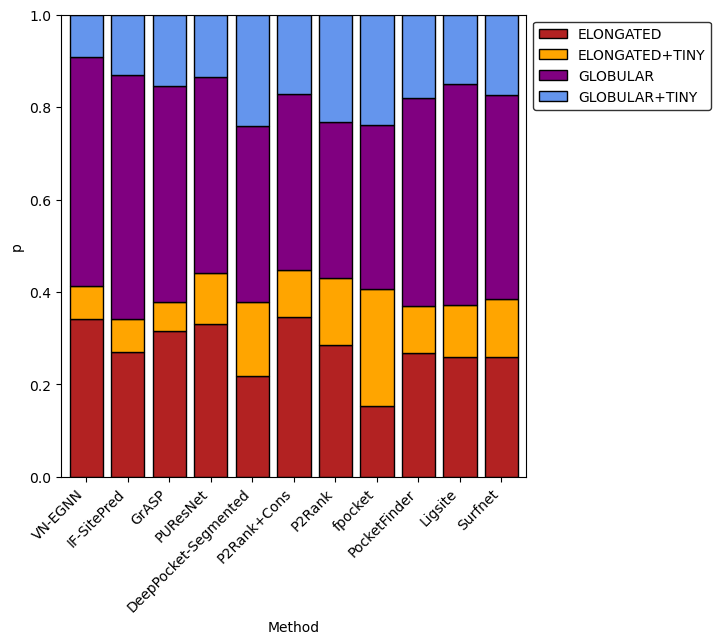

In [51]:
# Call the function with the dataframe
plot_stacked_barplot_f1_ward(f1_scores_df_SHAPE.query('f1_score == 0'), order = TARGETS, col = "SHAPE", palette = protein_class_palette)

## Plotting MCC

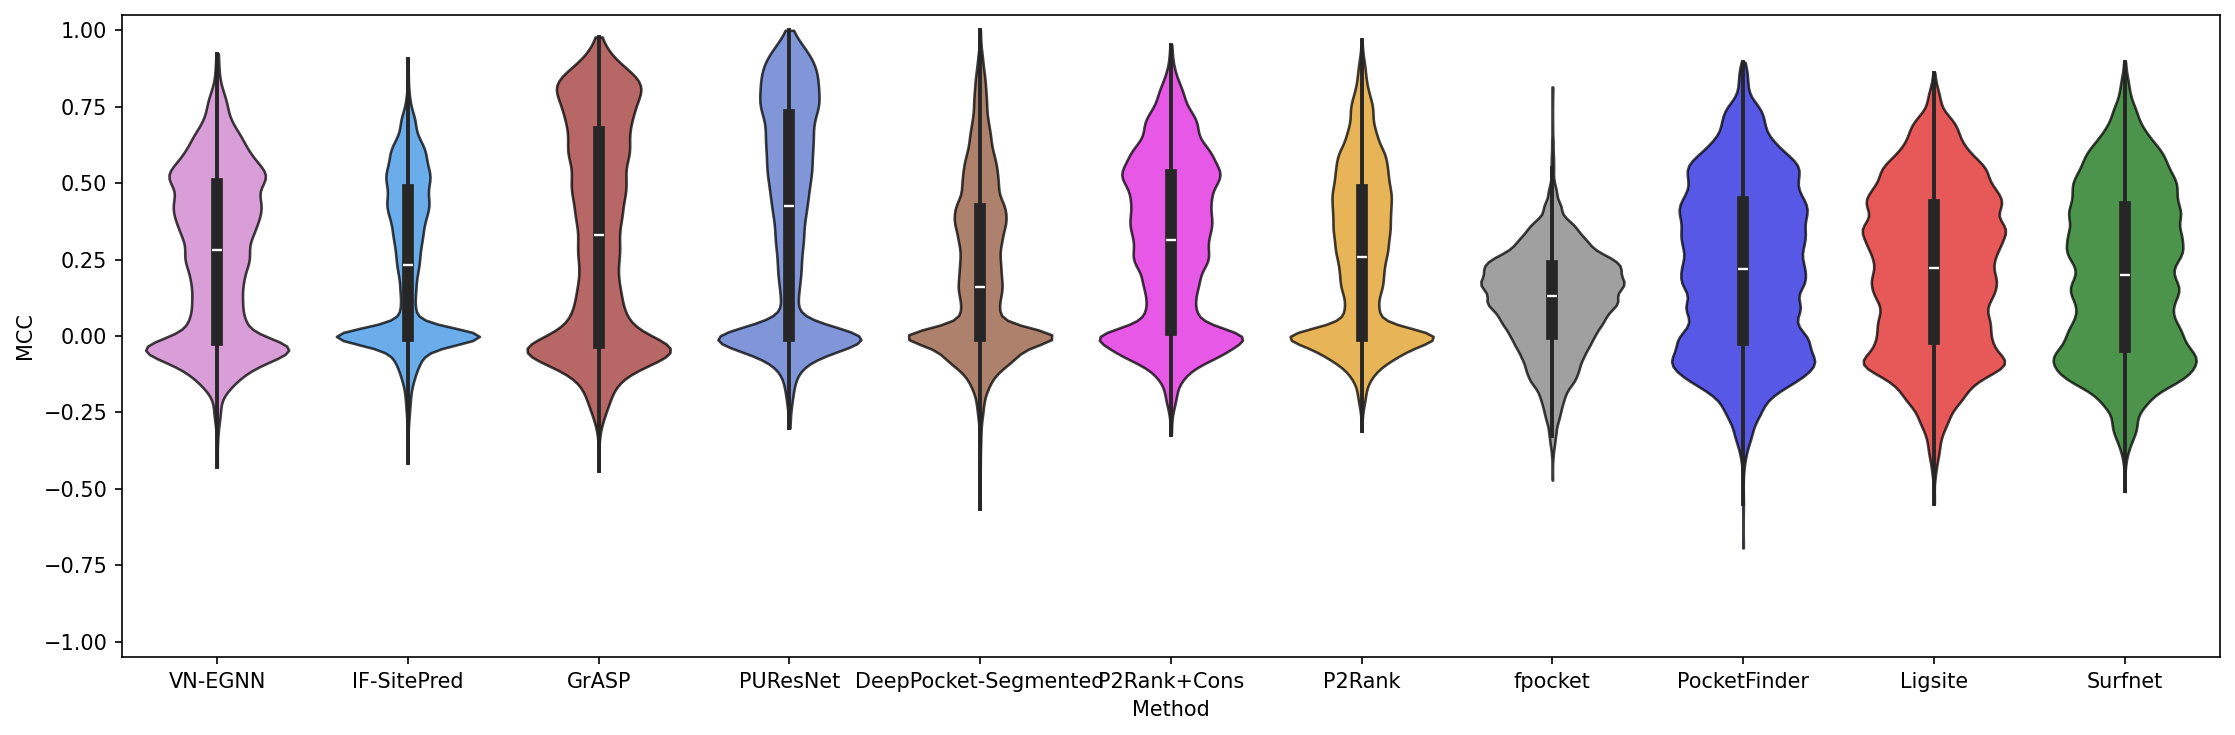

In [52]:
my_order = TARGETS

plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="MCC", data=MCCs_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.5, inner = "box", alpha = 0.75,
)

for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15 
        violin.set_facecolor(facecolor)

plt.xlabel('Method')
plt.ylabel('MCC')

plt.ylim(-1.05, 1.05)
plt.tight_layout()
#plt.savefig("./figs/MCC_violins.png")
plt.show()

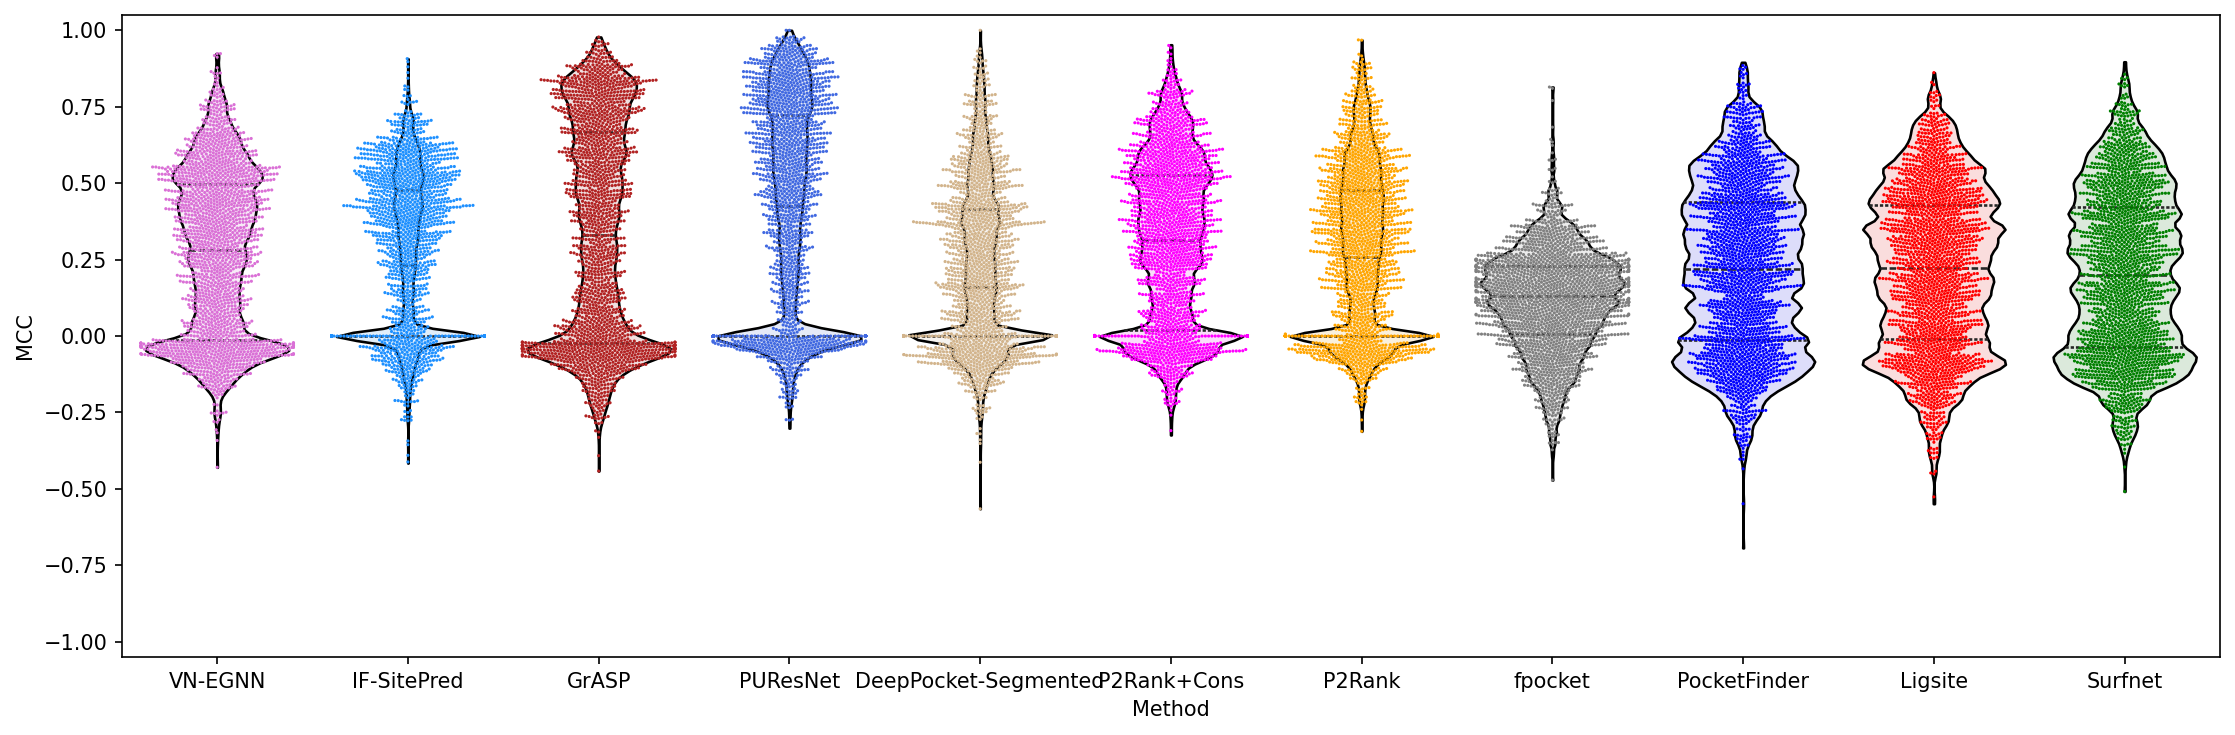

In [83]:
# Subsampling each method to 50 samples (adjust the number as needed)
subsampled_MCCs_df = MCCs_df.groupby('method').apply(lambda x: x.sample(min(2000, len(x)))).reset_index(drop=True)

plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="MCC", data=MCCs_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.3, inner = "quart"
)

# Manually set the edgecolor and facecolor for each violin
for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  # Set edge color to black
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15  # Set alpha for face color
        violin.set_facecolor(facecolor)

# Adding the swarm plot on top
sns.swarmplot(x="method", y="MCC", data=subsampled_MCCs_df, palette=palette, alpha=1, size=1.5, order=my_order)

plt.xlabel('Method')
plt.ylabel('MCC')

plt.ylim(-1.05, 1.05)
plt.tight_layout()
plt.show()

In [58]:
MCCs_df.query('MCC == 0').method.value_counts()

IF-SitePred             700
DeepPocket-Segmented    427
PUResNet                415
P2Rank                  373
P2Rank+Cons             196
fpocket                  17
VN-EGNN                  12
GrASP                     6
Surfnet                   2
PocketFinder              2
Ligsite                   1
Name: method, dtype: int64

In [12]:
f1_scores_df.groupby("method").mean().sort_values("f1_score", ascending = False).round(4)

f1_score
method                        
PUResNet                0.4058
GrASP                   0.3874
P2Rank+Cons             0.3553
P2Rank                  0.3125
PocketFinder            0.3069
Ligsite                 0.3062
Surfnet                 0.2930
VN-EGNN                 0.2930
IF-SitePred             0.2908
DeepPocket-Segmented    0.2708
fpocket                 0.2302

In [13]:
MCCs_df.groupby("method").mean().sort_values("MCC", ascending = False).round(4)

MCC
method                      
PUResNet              0.3896
GrASP                 0.3351
P2Rank+Cons           0.3012
VN-EGNN               0.2643
P2Rank                0.2637
IF-SitePred           0.2411
PocketFinder          0.2199
Ligsite               0.2146
DeepPocket-Segmented  0.2145
Surfnet               0.2038
fpocket               0.1155

## All F1 scores

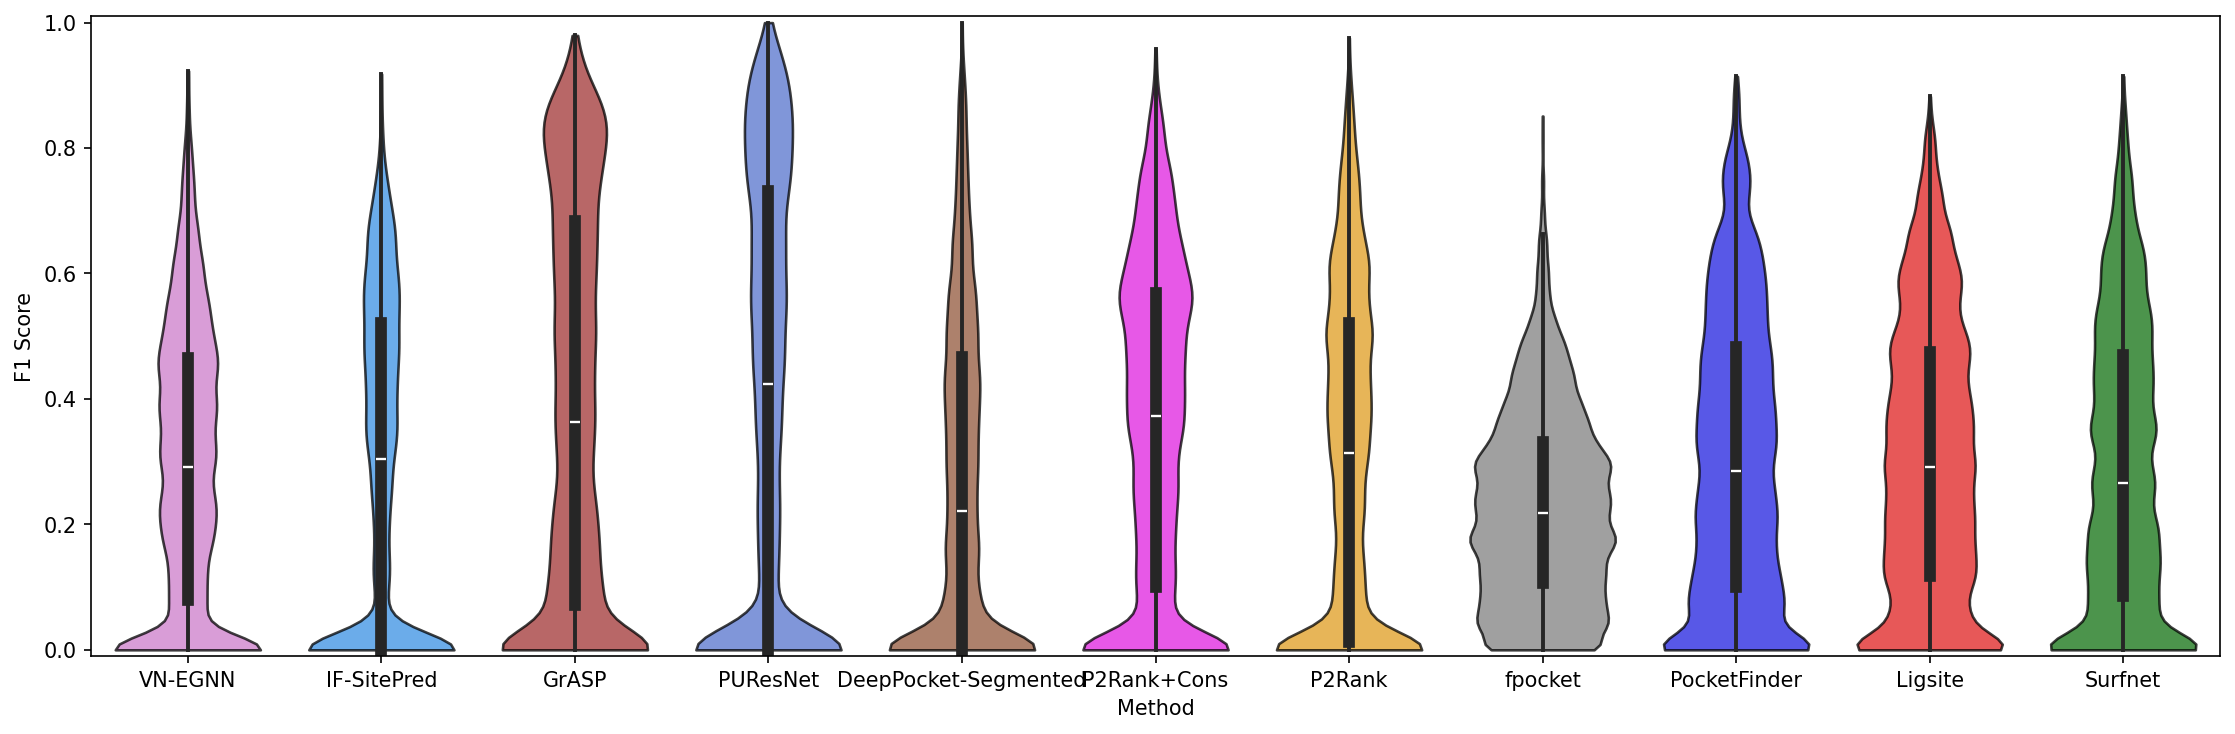

In [55]:
plt.figure(figsize=(15, 5), dpi=150)
ax = sns.violinplot(
    x="method", y="f1_score", data=f1_scores_df, palette=palette, cut=0,
    fill=True, linewidth=1.25, width=0.75, order=my_order, bw_adjust=0.5, inner = "box", alpha = 0.75,
)

# Manually set the edgecolor and facecolor for each violin
for violin in ax.collections:
    if isinstance(violin, PolyCollection):
        violin.set_edgecolor('k')  # Set edge color to black
        facecolor = violin.get_facecolor()
        facecolor[:, -1] = 0.15  # Set alpha for face color
        violin.set_facecolor(facecolor)

plt.xlabel('Method')
plt.ylabel('F1 Score')

plt.ylim(-0.01, 1.01)
plt.tight_layout()
#plt.savefig("./figs/F1_violins.png")
plt.show()

## Using ligandability scores (IF-SitePred, GrASP, P2Rank+Cons, P2Rank)

In [62]:
errors = []
dfs = []
for i, rep_chain in enumerate(LIGYSIS_reps):
    
    GRASP_scores_df = PDBXreader(inputfile = os.path.join(GRASP_preds_dir, f'{rep_chain}_probs.pdb')).atoms(format_type = "pdb", excluded=())
    #sorted_keys = custom_sort(GRASP_scores_dict.keys())
    GRASP_scores_dict = GRASP_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()
    #GRASP_scores_dict = {key: GRASP_scores_dict[key] for key in sorted_keys}
    
    IFSP_scores_dict = read_from_pickle(os.path.join(IFSP_preds_dir, rep_chain, f'{rep_chain}_lig_scores.pkl')) # IFSP
    
    P2RANK_scores_df = pd.read_csv(os.path.join(P2RANK_preds_dir, f'{rep_chain}.trans.pdb_residues.csv')) #P2RANK
    P2RANK_scores_df = fix_col_names(P2RANK_scores_df)

    P2RANK_cons_scores_df = pd.read_csv(os.path.join(P2RANK_cons_preds_dir, f'{rep_chain}.trans.pdb_residues.csv')) #P2RANK_CONS
    P2RANK_cons_scores_df = fix_col_names(P2RANK_cons_scores_df)
    P2RANK_cons_scores_df.residue_label = P2RANK_cons_scores_df.residue_label.astype(str)
    P2RANK_cons_dict = dict(zip(P2RANK_cons_scores_df.residue_label, P2RANK_cons_scores_df.probability))

    PocketFinder_scores_df = PDBXreader(inputfile = os.path.join(PocketFinder_preds_dir, f'{rep_chain}.clean_pocketfinder_residue.pdb')).atoms(format_type = "pdb", excluded=())
    PocketFinder_score_dict = PocketFinder_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    Ligsite_scores_df = PDBXreader(inputfile = os.path.join(Ligsite_preds_dir, f'{rep_chain}.clean_ligsite_residue.pdb')).atoms(format_type = "pdb", excluded=())
    Ligsite_score_dict = Ligsite_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    Surfnet_scores_df = PDBXreader(inputfile = os.path.join(Surfnet_preds_dir, f'{rep_chain}.clean_surfnet_residue.pdb')).atoms(format_type = "pdb", excluded=())
    Surfnet_score_dict = Surfnet_scores_df.groupby('label_seq_id_full')['B_iso_or_equiv'].mean().round(2).to_dict()

    CORE_df = P2RANK_scores_df[["chain", "residue_label", "residue_name", "probability"]]
    CORE_df.rename(columns = {"residue_label": "resnum", "residue_name": "resname", "probability": "P2Rank"}, inplace = True)
    CORE_df.resnum = CORE_df.resnum.astype(str)
    CORE_df['resname'] = CORE_df['resname'].str.strip()
    CORE_df["rep_chain"] = rep_chain
    CORE_df["GrASP"] = CORE_df.resnum.map(GRASP_scores_dict)
    CORE_df["IF-SitePred"] = CORE_df.resnum.map(IFSP_scores_dict)
    CORE_df["P2Rank+Cons"] = CORE_df.resnum.map(P2RANK_cons_dict)
    CORE_df["PocketFinder"] = CORE_df.resnum.map(PocketFinder_score_dict)
    CORE_df["Ligsite"] = CORE_df.resnum.map(Ligsite_score_dict)
    CORE_df["Surfnet"] = CORE_df.resnum.map(Surfnet_score_dict)

    dfs.append(CORE_df)
    
ligandability_df = pd.concat(dfs).reset_index(drop = True)[["rep_chain", "chain", "resnum", "resname", "IF-SitePred", "GrASP", "P2Rank+Cons", "P2Rank", "PocketFinder", "Ligsite", "Surfnet"]]

In [65]:
ligandability_df

rep_chain chain resnum resname  IF-SitePred  GrASP  P2Rank+Cons  \
0         1a52_A     A     10     LEU         0.11   0.00       0.0029   
1         1a52_A     A     11     ALA         0.20   0.00       0.0044   
2         1a52_A     A     12     LEU         0.24   0.00       0.0032   
3         1a52_A     A     13     SER         0.15   0.00       0.0007   
4         1a52_A     A     14     LEU         0.10   0.00       0.0032   
...          ...   ...    ...     ...          ...    ...          ...   
831567    8y6o_H     H    140     PRO         0.71   0.13       0.0668   
831568    8y6o_H     H    141     LYS         0.44   0.44       0.0669   
831569    8y6o_H     H    142     TYR         0.77   0.04       0.0617   
831570    8y6o_H     H    143     ASP         0.35   0.05       0.0070   
831571    8y6o_H     H    144     LEU         0.45   0.13       0.0578   

        P2Rank  PocketFinder  Ligsite  Surfnet  
0       0.0159          0.03     0.00     0.00  
1       0.0168          0.02     0.00     0.00  
2       0.0104          0.01     0.00     0.00  
3       0.0005          0.00     0.00     0.00  
4       0.0113          0.03     0.00     0.00  
...        ...           ...      ...      ...  
831567  0.0511          0.03     0.30     4.84  
831568  0.0297          0.05     0.34     6.21  
831569  0.0446          0.04     0.27     4.25  
831570  0.0009          0.03     0.20     3.38  
831571  0.0054          0.07     0.38     8.76  

[831572 rows x 11 columns]

In [66]:
ligandability_df.to_pickle("./results/ligandability_df.pkl")

In [14]:
ligandability_df = pd.read_pickle("./results/ligandability_df.pkl")

In [15]:
ligandability_df["TRUE_LABEL"] = ligandability_df.set_index(["rep_chain", "chain", "resnum", "resname"]).index.map(TRUE_labels_dict.get)

In [16]:
len(ligandability_df.rep_chain.unique())#LIGYSIS_reps

2775

In [18]:
ligandability_df.head(20)

rep_chain chain resnum resname  IF-SitePred  GrASP  P2Rank+Cons  P2Rank  \
0     1a52_A     A     10     LEU         0.11    0.0       0.0029  0.0159   
1     1a52_A     A     11     ALA         0.20    0.0       0.0044  0.0168   
2     1a52_A     A     12     LEU         0.24    0.0       0.0032  0.0104   
3     1a52_A     A     13     SER         0.15    0.0       0.0007  0.0005   
4     1a52_A     A     14     LEU         0.10    0.0       0.0032  0.0113   
5     1a52_A     A     15     THR         0.10    0.0       0.0016  0.0010   
6     1a52_A     A     16     ALA         0.04    0.0       0.0021  0.0016   
7     1a52_A     A     17     ASP         0.04    0.0       0.0018  0.0013   
8     1a52_A     A     18     GLN         0.05    0.0       0.0006  0.0008   
9     1a52_A     A     19     MET         0.07    0.0       0.0005  0.0003   
10    1a52_A     A     20     VAL         0.11    0.0       0.0006  0.0005   
11    1a52_A     A     21     SER         0.06    0.0       0.0006  0.0005   
12    1a52_A     A     22     ALA         0.06    0.0       0.0017  0.0018   
13    1a52_A     A     23     LEU         0.19    0.0       0.0009  0.0006   
14    1a52_A     A     24     LEU         0.09    0.0       0.0034  0.0079   
15    1a52_A     A     25     ASP         0.08    0.0       0.0006  0.0004   
16    1a52_A     A     26     ALA         0.07    0.0       0.0008  0.0005   
17    1a52_A     A     27     GLU         0.16    0.0       0.0431  0.0710   
18    1a52_A     A     28     PRO         0.70    0.0       0.0719  0.0478   
19    1a52_A     A     29     PRO         0.21    0.0       0.0107  0.0121   

    PocketFinder  Ligsite  Surfnet  TRUE_LABEL  
0           0.03     0.00     0.00         0.0  
1           0.02     0.00     0.00         0.0  
2           0.01     0.00     0.00         0.0  
3           0.00     0.00     0.00         0.0  
4           0.03     0.00     0.00         0.0  
5           0.00     0.00     0.00         0.0  
6           0.00     0.00     0.00         0.0  
7           0.00     0.00     0.00         0.0  
8           0.01     0.00     0.00         0.0  
9           0.01     0.00     0.01         0.0  
10          0.00     0.00     0.05         0.0  
11          0.01     0.00     0.05         0.0  
12          0.02     0.00     0.15         0.0  
13          0.01     0.03     1.04         0.0  
14          0.01     0.03     1.07         0.0  
15          0.01     0.02     0.71         0.0  
16          0.01     0.10     3.20         0.0  
17          0.04     0.29     8.88         0.0  
18          0.04     0.52    14.48         0.0  
19          0.03     0.43     9.12         0.0

In [24]:
ligandability_df_FILT = ligandability_df[~ligandability_df.isna().any(axis=1)].copy().reset_index(drop = True)
ligandability_df_FILT.TRUE_LABEL = ligandability_df_FILT.TRUE_LABEL.astype(int)

In [62]:
methods = ['IF-SitePred', 'GrASP', 'P2Rank+Cons', 'P2Rank', 'PocketFinder', 'Ligsite', 'Surfnet']

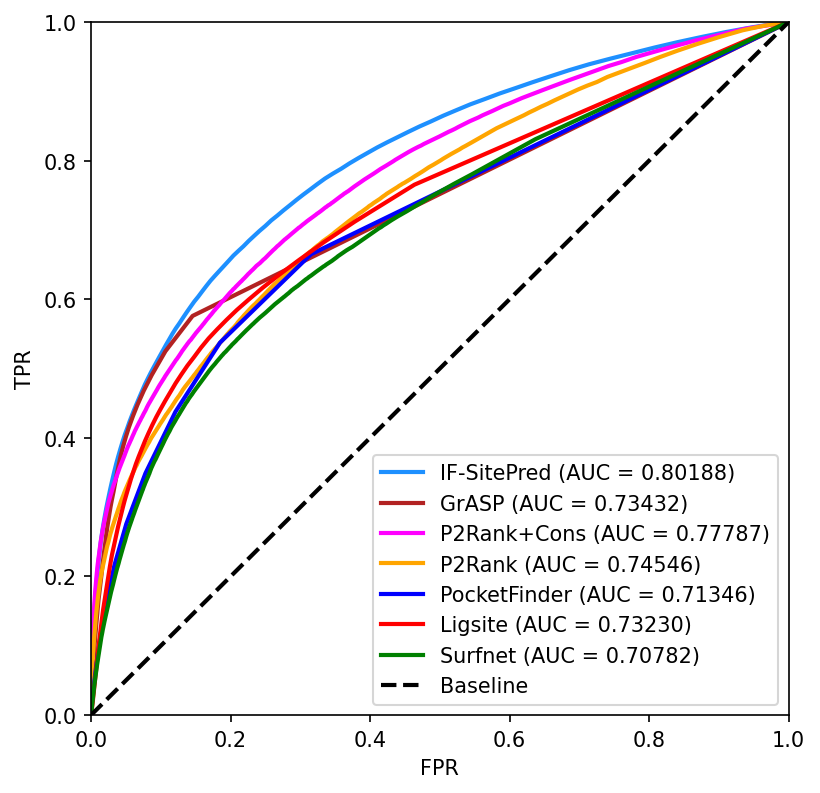

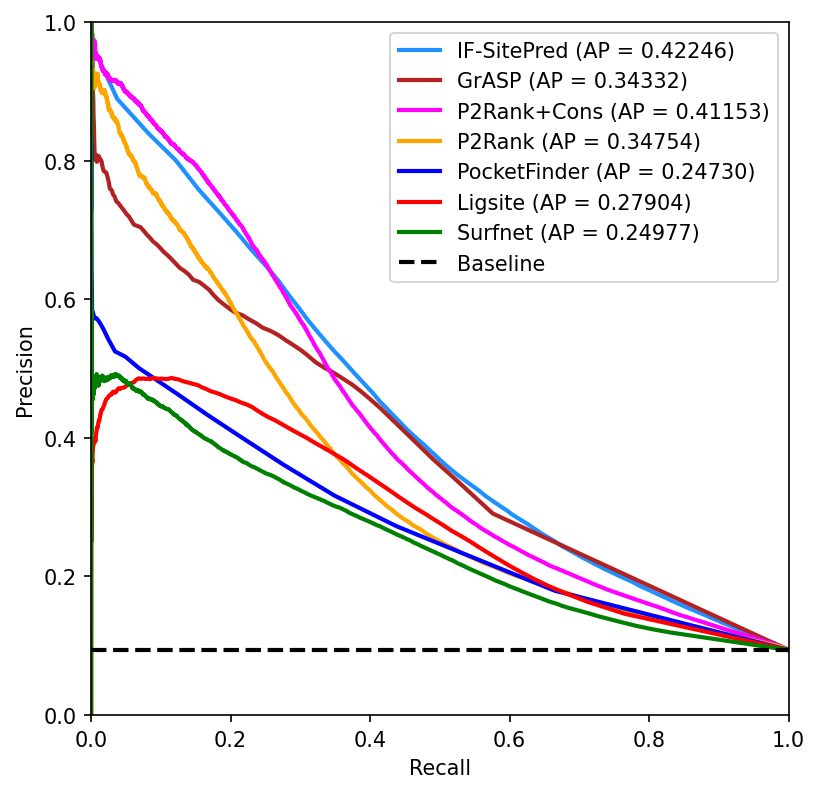

In [23]:
# Assuming you have the dataframe loaded as ligandability_df_FILT
methods = ['IF-SitePred', 'GrASP', 'P2Rank+Cons', 'P2Rank', 'PocketFinder', 'Ligsite', 'Surfnet']
true_label_col = 'TRUE_LABEL'

plot_roc_curve(
    ligandability_df_FILT, methods, true_label_col, palette,
    DPI = 150,
    #out = "./figs/ROC_AUC_residue_level_LEG.png"
)

plot_precision_recall_curve(
    ligandability_df_FILT, methods, true_label_col, palette,
    DPI = 150,
    #out = "./figs/PR_AUC_residue_level_LEG.png"
)

In [44]:
def plot_roc_curve_per_protein(df, method, true_label_col, palette, DPI=100, out=None, N_curves = 1):
    plt.figure(figsize=(6, 6), dpi=DPI)
    
    # Get unique proteins from rep_chain
    unique_proteins = df['rep_chain'].unique()
    aucs = []
    fprs = []
    tprs = []
    for protein in unique_proteins[:N_curves]:
        # Subset data for the current protein
        protein_df = df[df['rep_chain'] == protein]
        
        # Calculate FPR, TPR for the given method and protein
        fpr, tpr, _ = roc_curve(protein_df[true_label_col], protein_df[method])
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve for the current protein
        plt.plot(fpr, tpr, lw=1, color = palette[method])#, label=f'{protein} (AUC = {roc_auc:.5f})')
        aucs.append(roc_auc)
        fprs.append(fpr)
        tprs.append(tpr)
    
    # Plot the baseline curve (diagonal line)
    plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Baseline')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    
    # Add legend
    plt.legend(loc="lower right", fontsize='small', ncol=2)
    
    # Save or show the plot
    if out is not None:
        plt.savefig(out)
    plt.show()
    return aucs, fprs, tprs


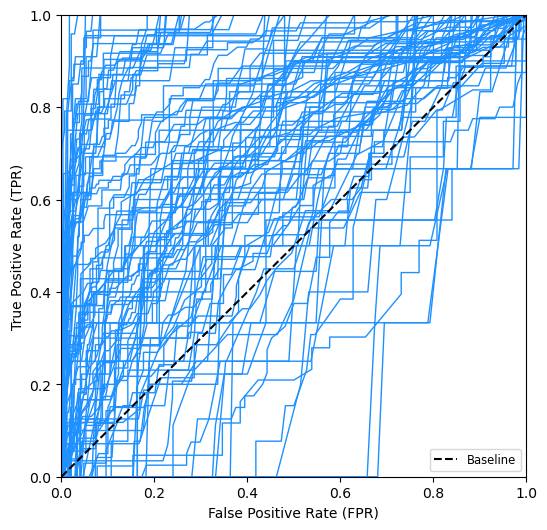

In [45]:
aucs, fprs, tprs = plot_roc_curve_per_protein(ligandability_df_FILT, method='IF-SitePred', true_label_col='TRUE_LABEL', palette = palette, N_curves = 100)

In [69]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def plot_mean_roc_curve(df, method, true_label_col, palette, DPI=100, out=None, N_curves=None):
    print(method)
    plt.figure(figsize=(6, 6), dpi=DPI)

    # Get unique proteins from rep_chain
    unique_proteins = df['rep_chain'].unique()
    
    if N_curves is not None:
        unique_proteins = unique_proteins[:N_curves]
    
    # Interpolating the ROC curves at common points (FPRs)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for protein in unique_proteins:
        protein_df = df[df['rep_chain'] == protein]
        fpr, tpr, _ = roc_curve(protein_df[true_label_col], protein_df[method])
        roc_auc = auc(fpr, tpr)
        
        # Interpolate the TPR at mean_fpr points
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)
        aucs.append(roc_auc)
    
    # Calculate mean and std deviation of TPR at each FPR
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    
    # Plot the mean ROC curve
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color=palette[method],
             label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
    
    # Plot the confidence interval (95%)
    tpr_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color=palette[method], alpha=0.2, label='95% CI')
    
    # Plot the baseline (diagonal line)
    plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Baseline')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    
    # Add legend
    plt.legend(loc="lower right", fontsize='small')
    
    # Save or show the plot
    if out is not None:
        plt.savefig(out)
    plt.show()

    return aucs


In [99]:
def plot_mean_roc_curve2(df, method, true_label_col, palette, DPI=100, out=None, N_curves=None):
    print(method)
    plt.figure(figsize=(6, 6), dpi=DPI)

    # Get unique proteins from rep_chain
    unique_proteins = df['rep_chain'].unique()
    
    if N_curves is not None:
        unique_proteins = unique_proteins[:N_curves]
    
    # Interpolating the ROC curves at common points (FPRs)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for protein in unique_proteins:
        protein_df = df[df['rep_chain'] == protein]
        fpr, tpr, _ = roc_curve(protein_df[true_label_col], protein_df[method])
        roc_auc = auc(fpr, tpr)
        
        # Interpolate the TPR at mean_fpr points
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tprs.append(tpr_interp)
        aucs.append(roc_auc)
    
    # Calculate mean and std deviation of TPR at each FPR
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    
    # Plot the mean ROC curve
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color=palette[method],
             label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
    
    # Plot the confidence interval (95%)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color=palette[method], alpha=0.2, label='95% CI')
    
    # Plot the baseline (diagonal line)
    plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Baseline')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    
    # Add legend
    plt.legend(loc="lower right", fontsize='small')
    
    # Save or show the plot
    if out is not None:
        plt.savefig(out)
    plt.show()

    return aucs, mean_fpr, tprs


In [84]:
for k, v in aucs_dict2.items():
    
    print(k, round(statistics.mean(v), 4))

IF-SitePred 0.7634
GrASP 0.6988
P2Rank+Cons 0.7648
P2Rank 0.7379
PocketFinder 0.682
Ligsite 0.6952
Surfnet 0.6797


## 1SD

IF-SitePred


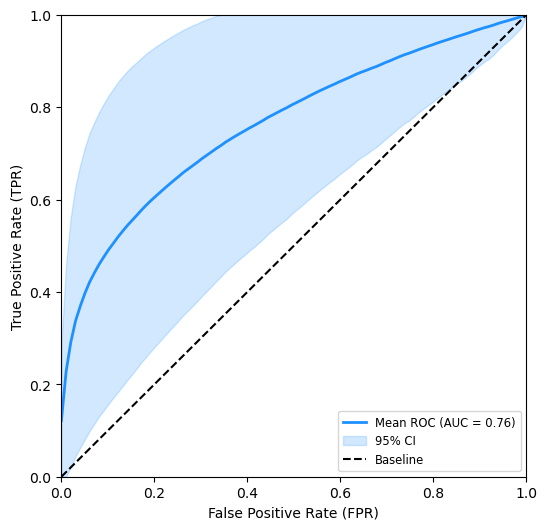

GrASP


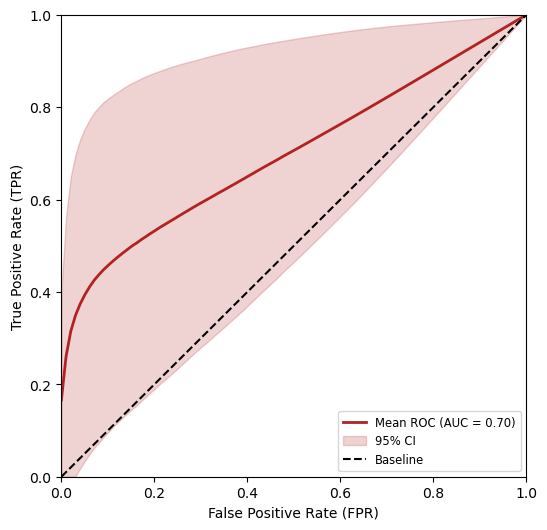

P2Rank+Cons


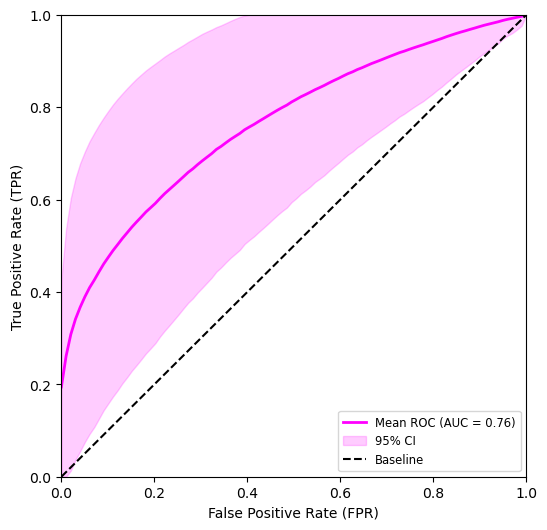

P2Rank


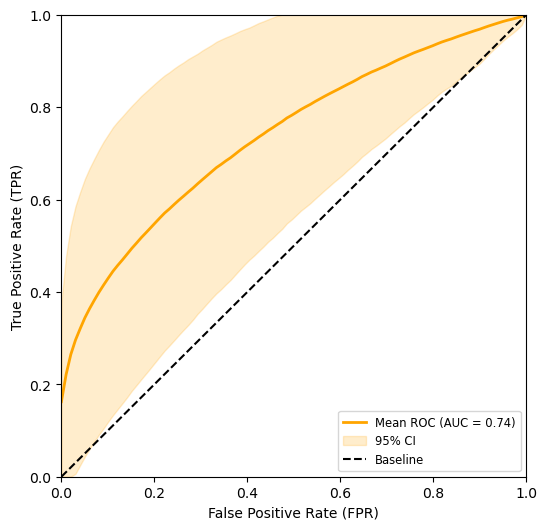

PocketFinder


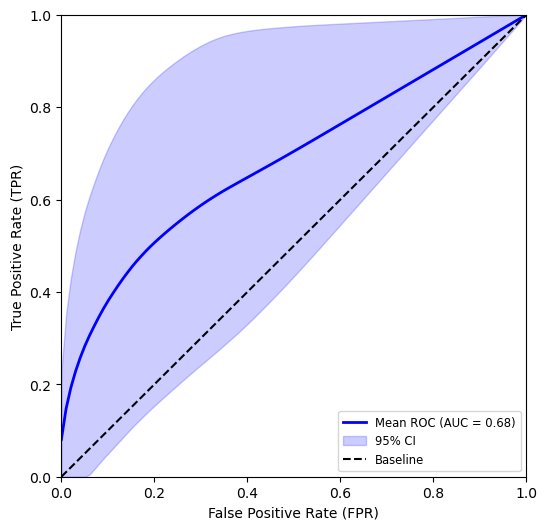

Ligsite


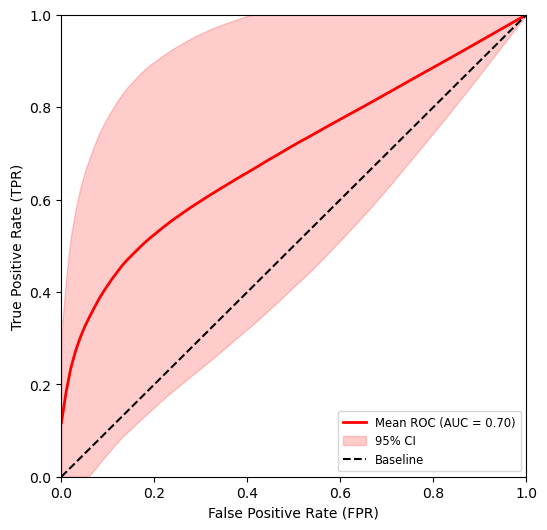

Surfnet


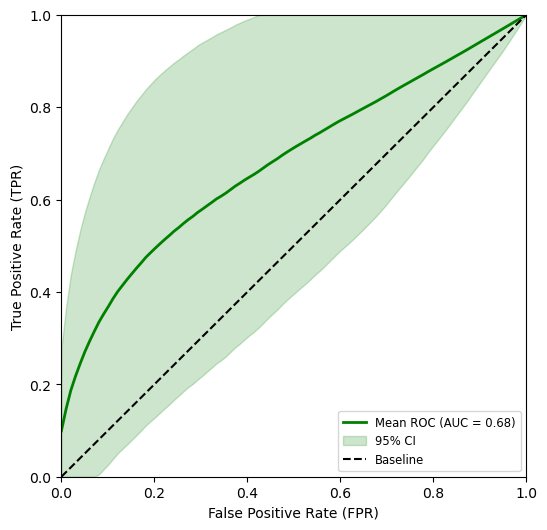

In [90]:
ROC_data = {}
for method in methods:
    ROC_data[method] = {}
    aucs, fprs, tprs = plot_mean_roc_curve2(ligandability_df_FILT, method=method, true_label_col='TRUE_LABEL', palette=palette, N_curves = None, DPI = 100)#, out = f"./figs/{method}_AUC_curves_1SD.png")
    ROC_data[method]["AUCs"] = aucs
    ROC_data[method]["FPRs"] = fprs
    ROC_data[method]["TPRs"] = tprs

In [93]:
save_to_pickle(ROC_data, "./results/ROC_AUC_variation.pkl")

IF-SitePred 0.7634221551278856
GrASP 0.6988420268757777
P2Rank+Cons 0.7648181397866748
P2Rank 0.7378716671177523
PocketFinder 0.6819523894645639
Ligsite 0.6951943985317364
Surfnet 0.6796788903273456


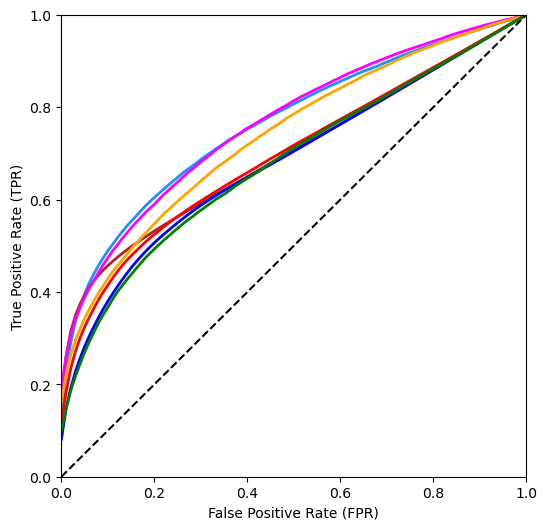

In [150]:

mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(6, 6), dpi=100)

for k, v in ROC_data.items():
    aucs = v["AUCs"]
    fprs = v["FPRs"]
    tprs = v["TPRs"]
    mean_tpr = np.mean(tprs, axis=0)
    
    mean_auc = statistics.mean(aucs)

    print(k, mean_auc)
    
    plt.plot(mean_fpr, mean_tpr, color=palette[k],
                 label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the baseline (diagonal line)
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Baseline')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

# Add legend
#plt.legend(loc="lower right", fontsize='small')
plt.legend().set_visible(False)

#plt.savefig("./figs/ROC_AUC_residue_level_MEANS.png")
    
plt.show()
    
    

## 95% CI

IF-SitePred


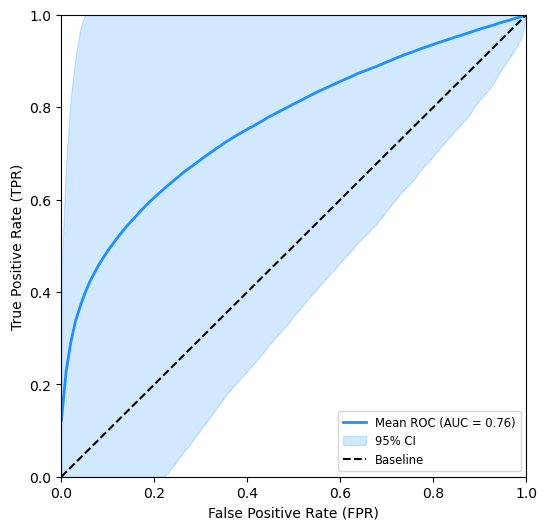

GrASP


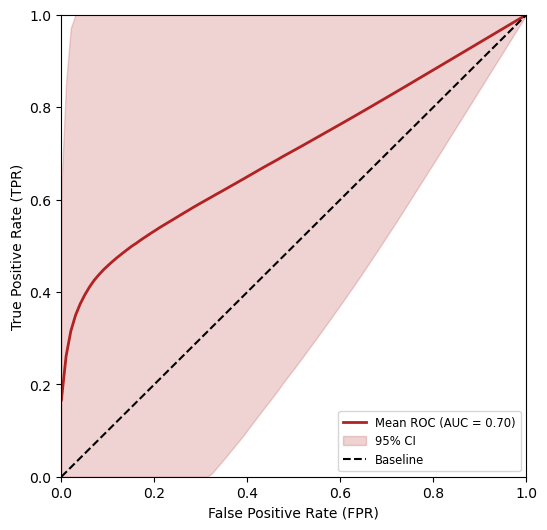

P2Rank+Cons


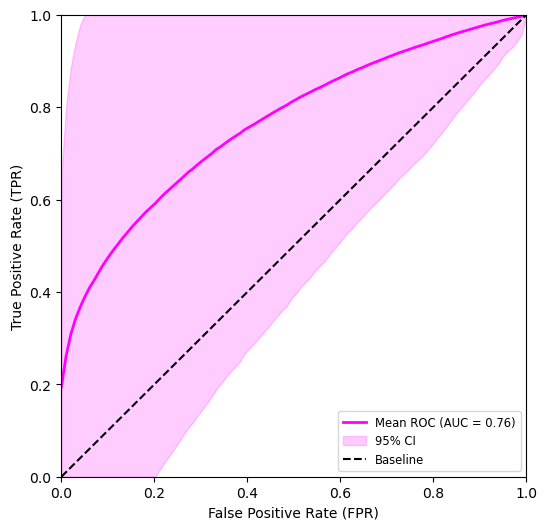

P2Rank


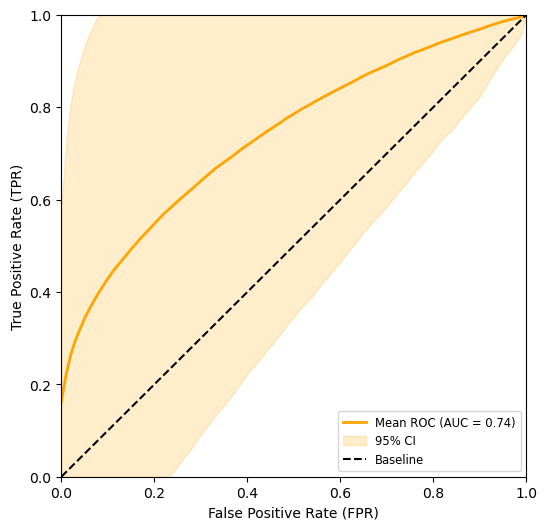

PocketFinder


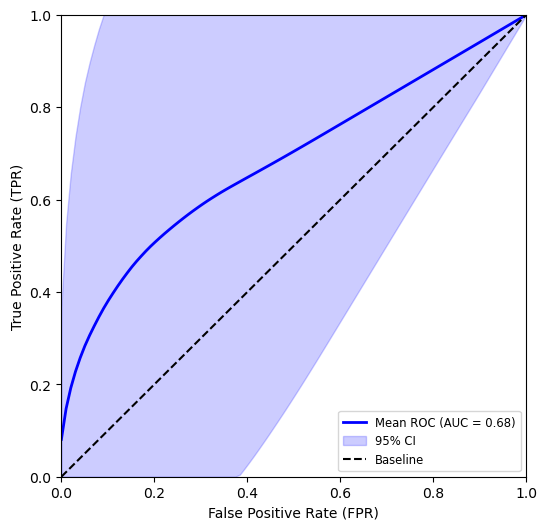

Ligsite


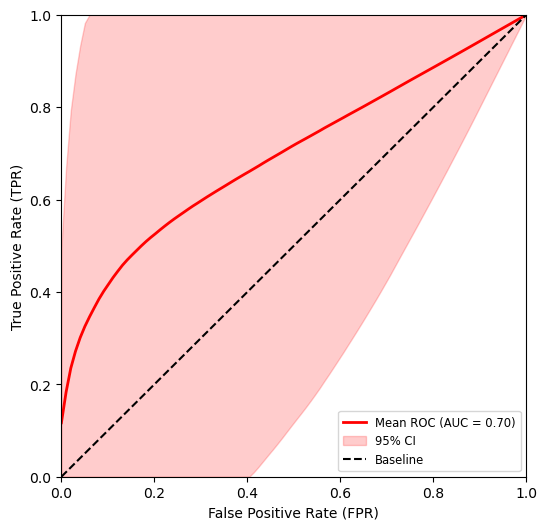

Surfnet


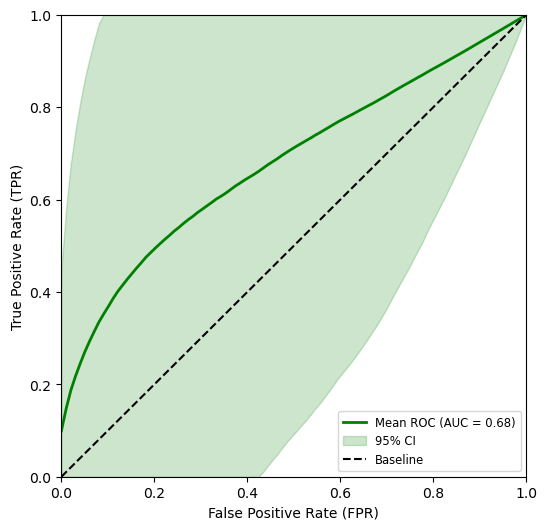

In [71]:
aucs_dict = {}
for method in methods:
    aucs = plot_mean_roc_curve(ligandability_df_FILT, method=method, true_label_col='TRUE_LABEL', palette=palette)
    aucs_dict[method] = aucs

# Variation in PR curve and AP

In [109]:
def plot_mean_precision_recall_curve(df, method, true_label_col, palette, DPI=100, out=None, N_curves=None):
    print(method)
    plt.figure(figsize=(6, 6), dpi=DPI)

    # Get unique proteins from rep_chain
    unique_proteins = df['rep_chain'].unique()
    
    if N_curves is not None:
        unique_proteins = unique_proteins[:N_curves]
    
    # Interpolating the precision-recall curves at common points (Recall)
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aps = []
    
    for protein in unique_proteins:
        protein_df = df[df['rep_chain'] == protein]
        precision, recall, _ = precision_recall_curve(protein_df[true_label_col], protein_df[method])
        ap = average_precision_score(protein_df[true_label_col], protein_df[method])
        
        # Interpolate the precision at mean_recall points
        precision_interp = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(precision_interp)
        aps.append(ap)
    
    # Calculate mean and std deviation of Precision at each Recall
    mean_precision = np.mean(precisions, axis=0)
    std_precision = np.std(precisions, axis=0)
    
    # Plot the mean Precision-Recall curve
    mean_ap = np.mean(aps)
    plt.plot(mean_recall, mean_precision, color=palette[method],
             label=f'Mean PR (AP = {mean_ap:.2f})', lw=2)
    
    # Plot the confidence interval (95% CI)
    precision_upper = np.minimum(mean_precision + 1.96 * std_precision, 1)
    precision_lower = np.maximum(mean_precision - 1.96 * std_precision, 0)
    plt.fill_between(mean_recall, precision_lower, precision_upper, color=palette[method], alpha=0.2, label='95% CI')
    
    # Plot the baseline (proportion of positive samples)
    positive_proportion = df[true_label_col].mean()
    plt.plot([0, 1], [positive_proportion, positive_proportion], color='black', lw=1.5, linestyle='--', label='Baseline')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Add legend
    plt.legend(loc="lower left", fontsize='small')
    
    # Save or show the plot
    if out is not None:
        plt.savefig(out)
    plt.show()

    return aps, mean_recall, precisions

def plot_mean_precision_recall_curve2(df, method, true_label_col, palette, DPI=100, out=None, N_curves=None):
    plt.figure(figsize=(6, 6), dpi=DPI)

    # Get unique proteins from rep_chain
    unique_proteins = df['rep_chain'].unique()
    
    if N_curves is not None:
        unique_proteins = unique_proteins[:N_curves]
    
    # Interpolating the precision-recall curves at common points (Recall)
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aps = []
    
    for protein in unique_proteins:
        protein_df = df[df['rep_chain'] == protein]
        precision, recall, _ = precision_recall_curve(protein_df[true_label_col], protein_df[method])
        ap = average_precision_score(protein_df[true_label_col], protein_df[method])
        
        # Interpolate the precision at mean_recall points
        precision_interp = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(precision_interp)
        aps.append(ap)
    
    # Calculate mean and std deviation of Precision at each Recall
    mean_precision = np.mean(precisions, axis=0)
    std_precision = np.std(precisions, axis=0)
    
    # Plot the mean Precision-Recall curve
    mean_ap = np.mean(aps)

    print(method, mean_ap)
    
    plt.plot(mean_recall, mean_precision, color=palette[method],
             label=f'Mean PR (AP = {mean_ap:.2f})', lw=2)
    
    # Plot the confidence interval (1 SD)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)
    plt.fill_between(mean_recall, precision_lower, precision_upper, color=palette[method], alpha=0.2, label='1 SD')
    
    # Plot the baseline (proportion of positive samples)
    positive_proportion = df[true_label_col].mean()
    plt.plot([0, 1], [positive_proportion, positive_proportion], color='black', lw=1.5, linestyle='--', label='Baseline')
    
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Add legend
    plt.legend().set_visible(False)
    
    # Save or show the plot
    if out is not None:
        plt.savefig(out)
    plt.show()

    return aps, mean_recall, precisions

IF-SitePred 0.44903966453772887


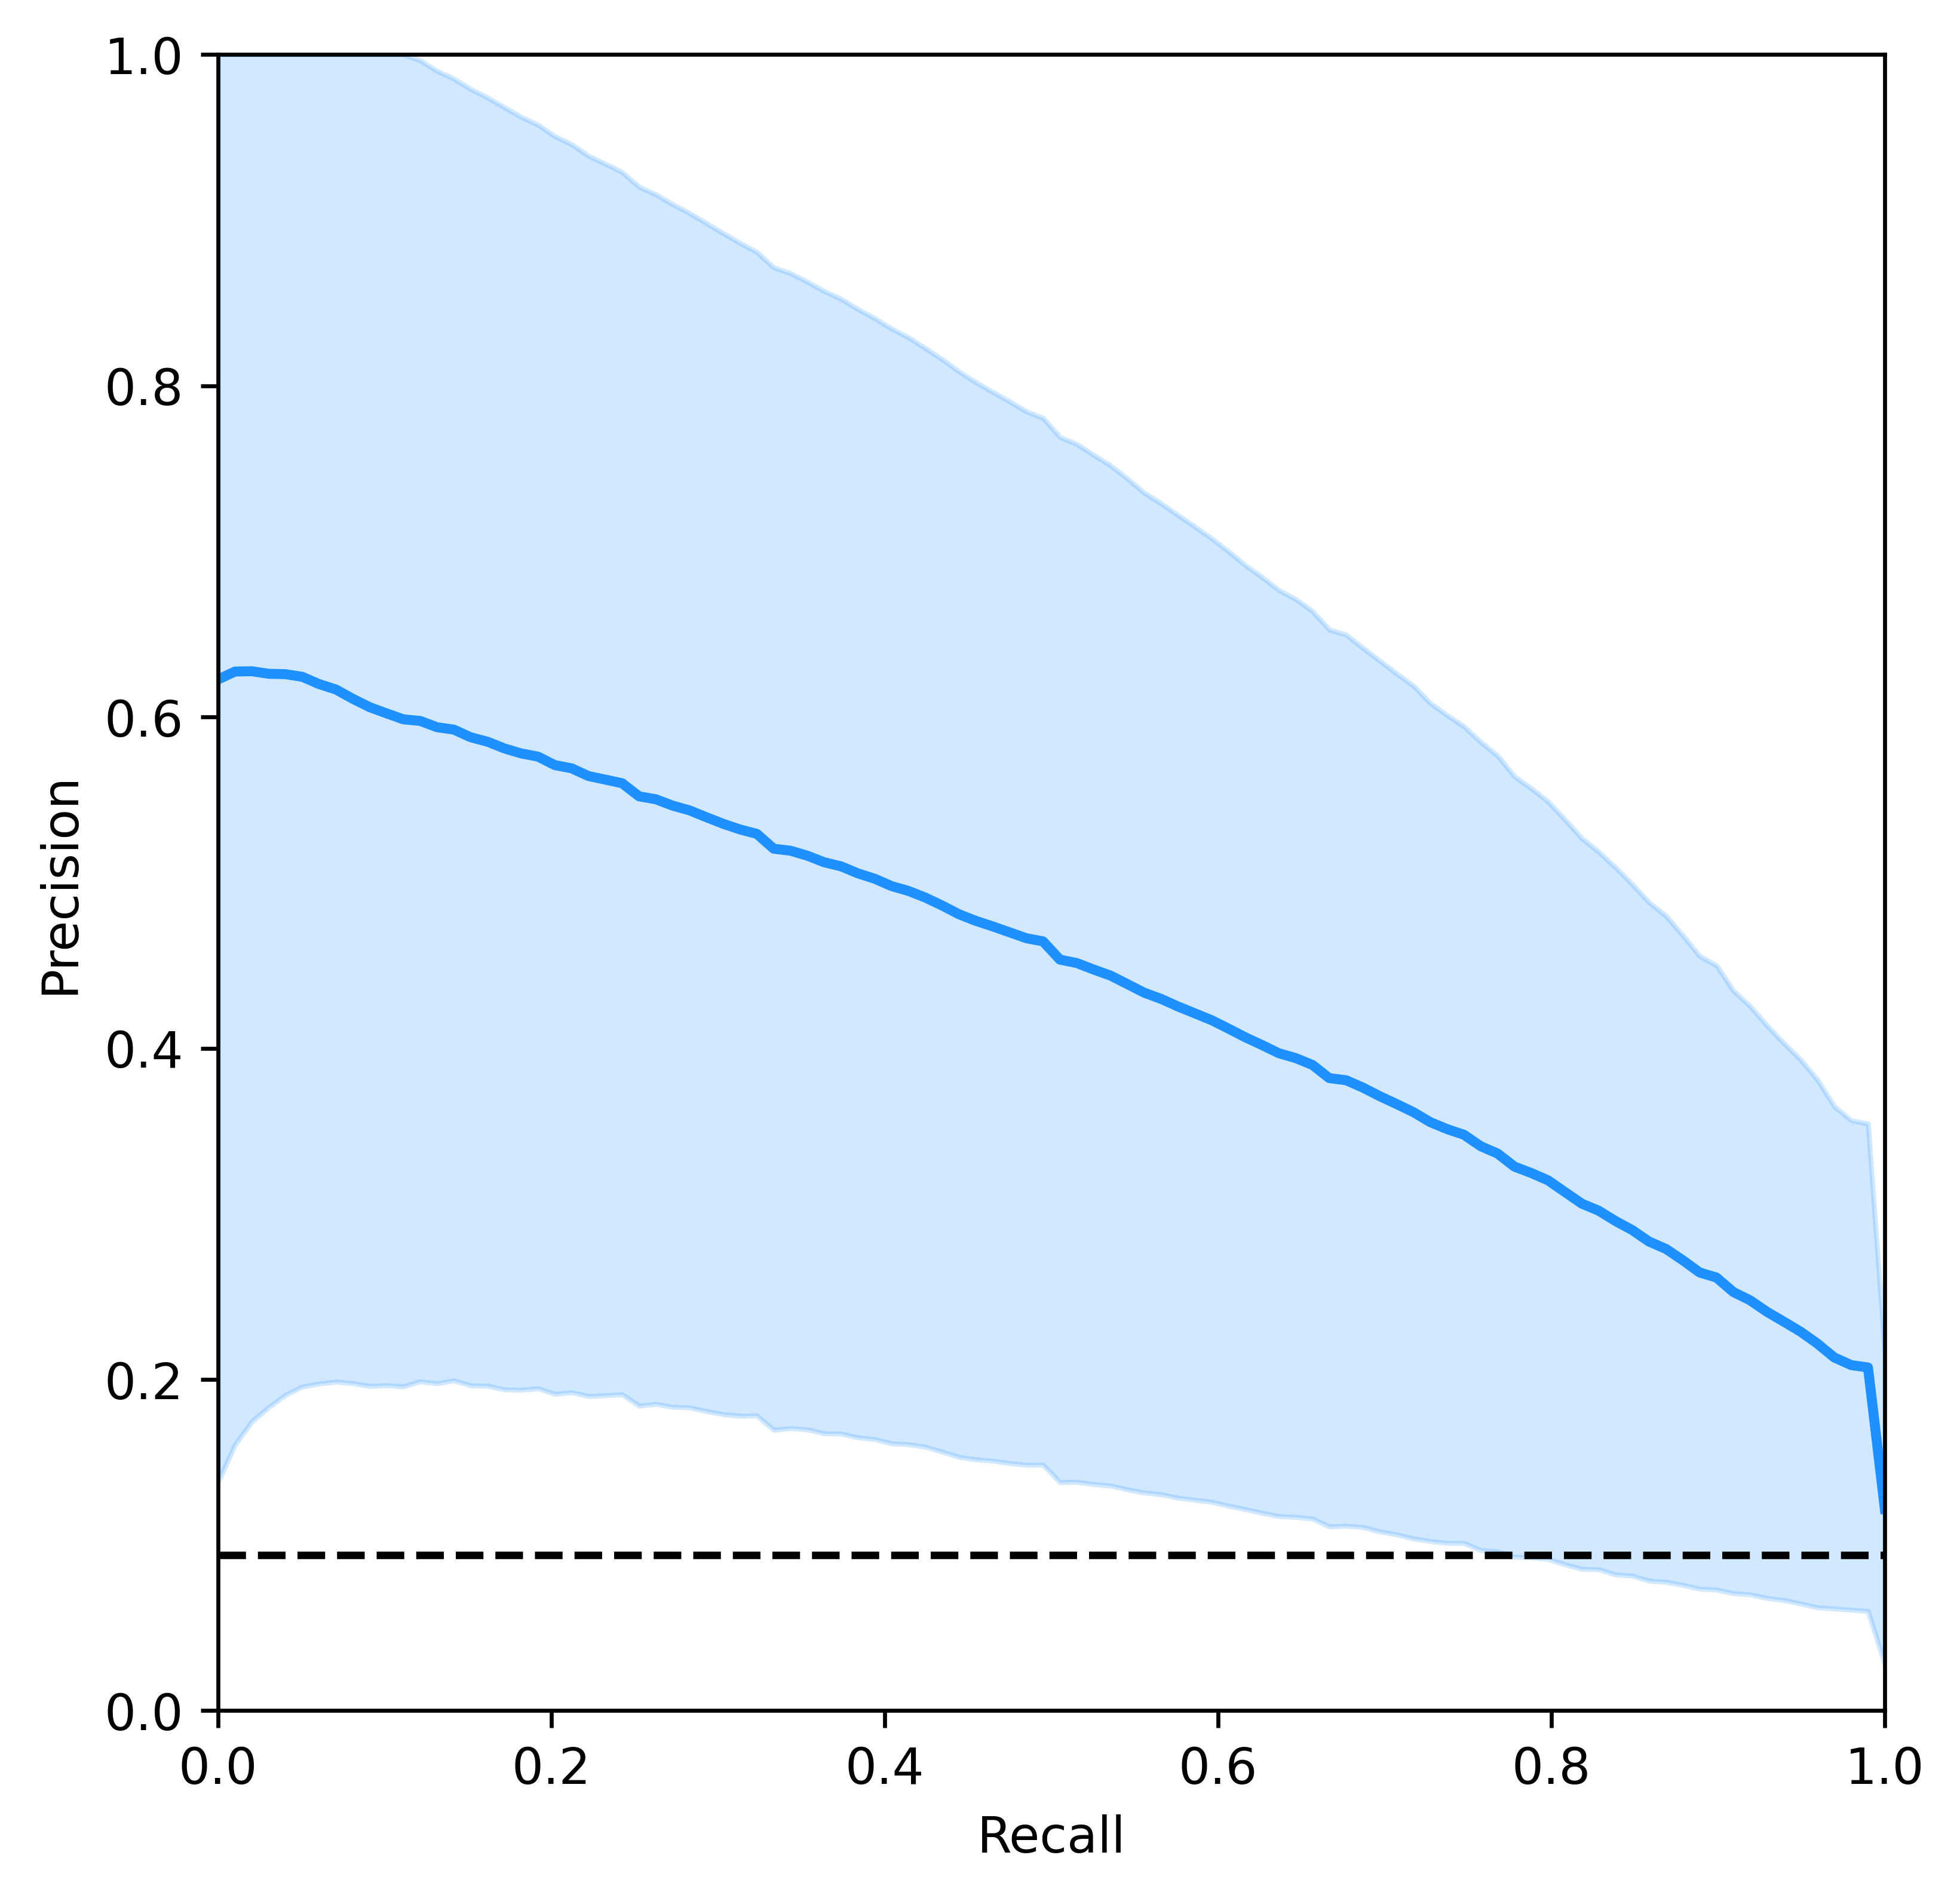

GrASP 0.4193894383930815


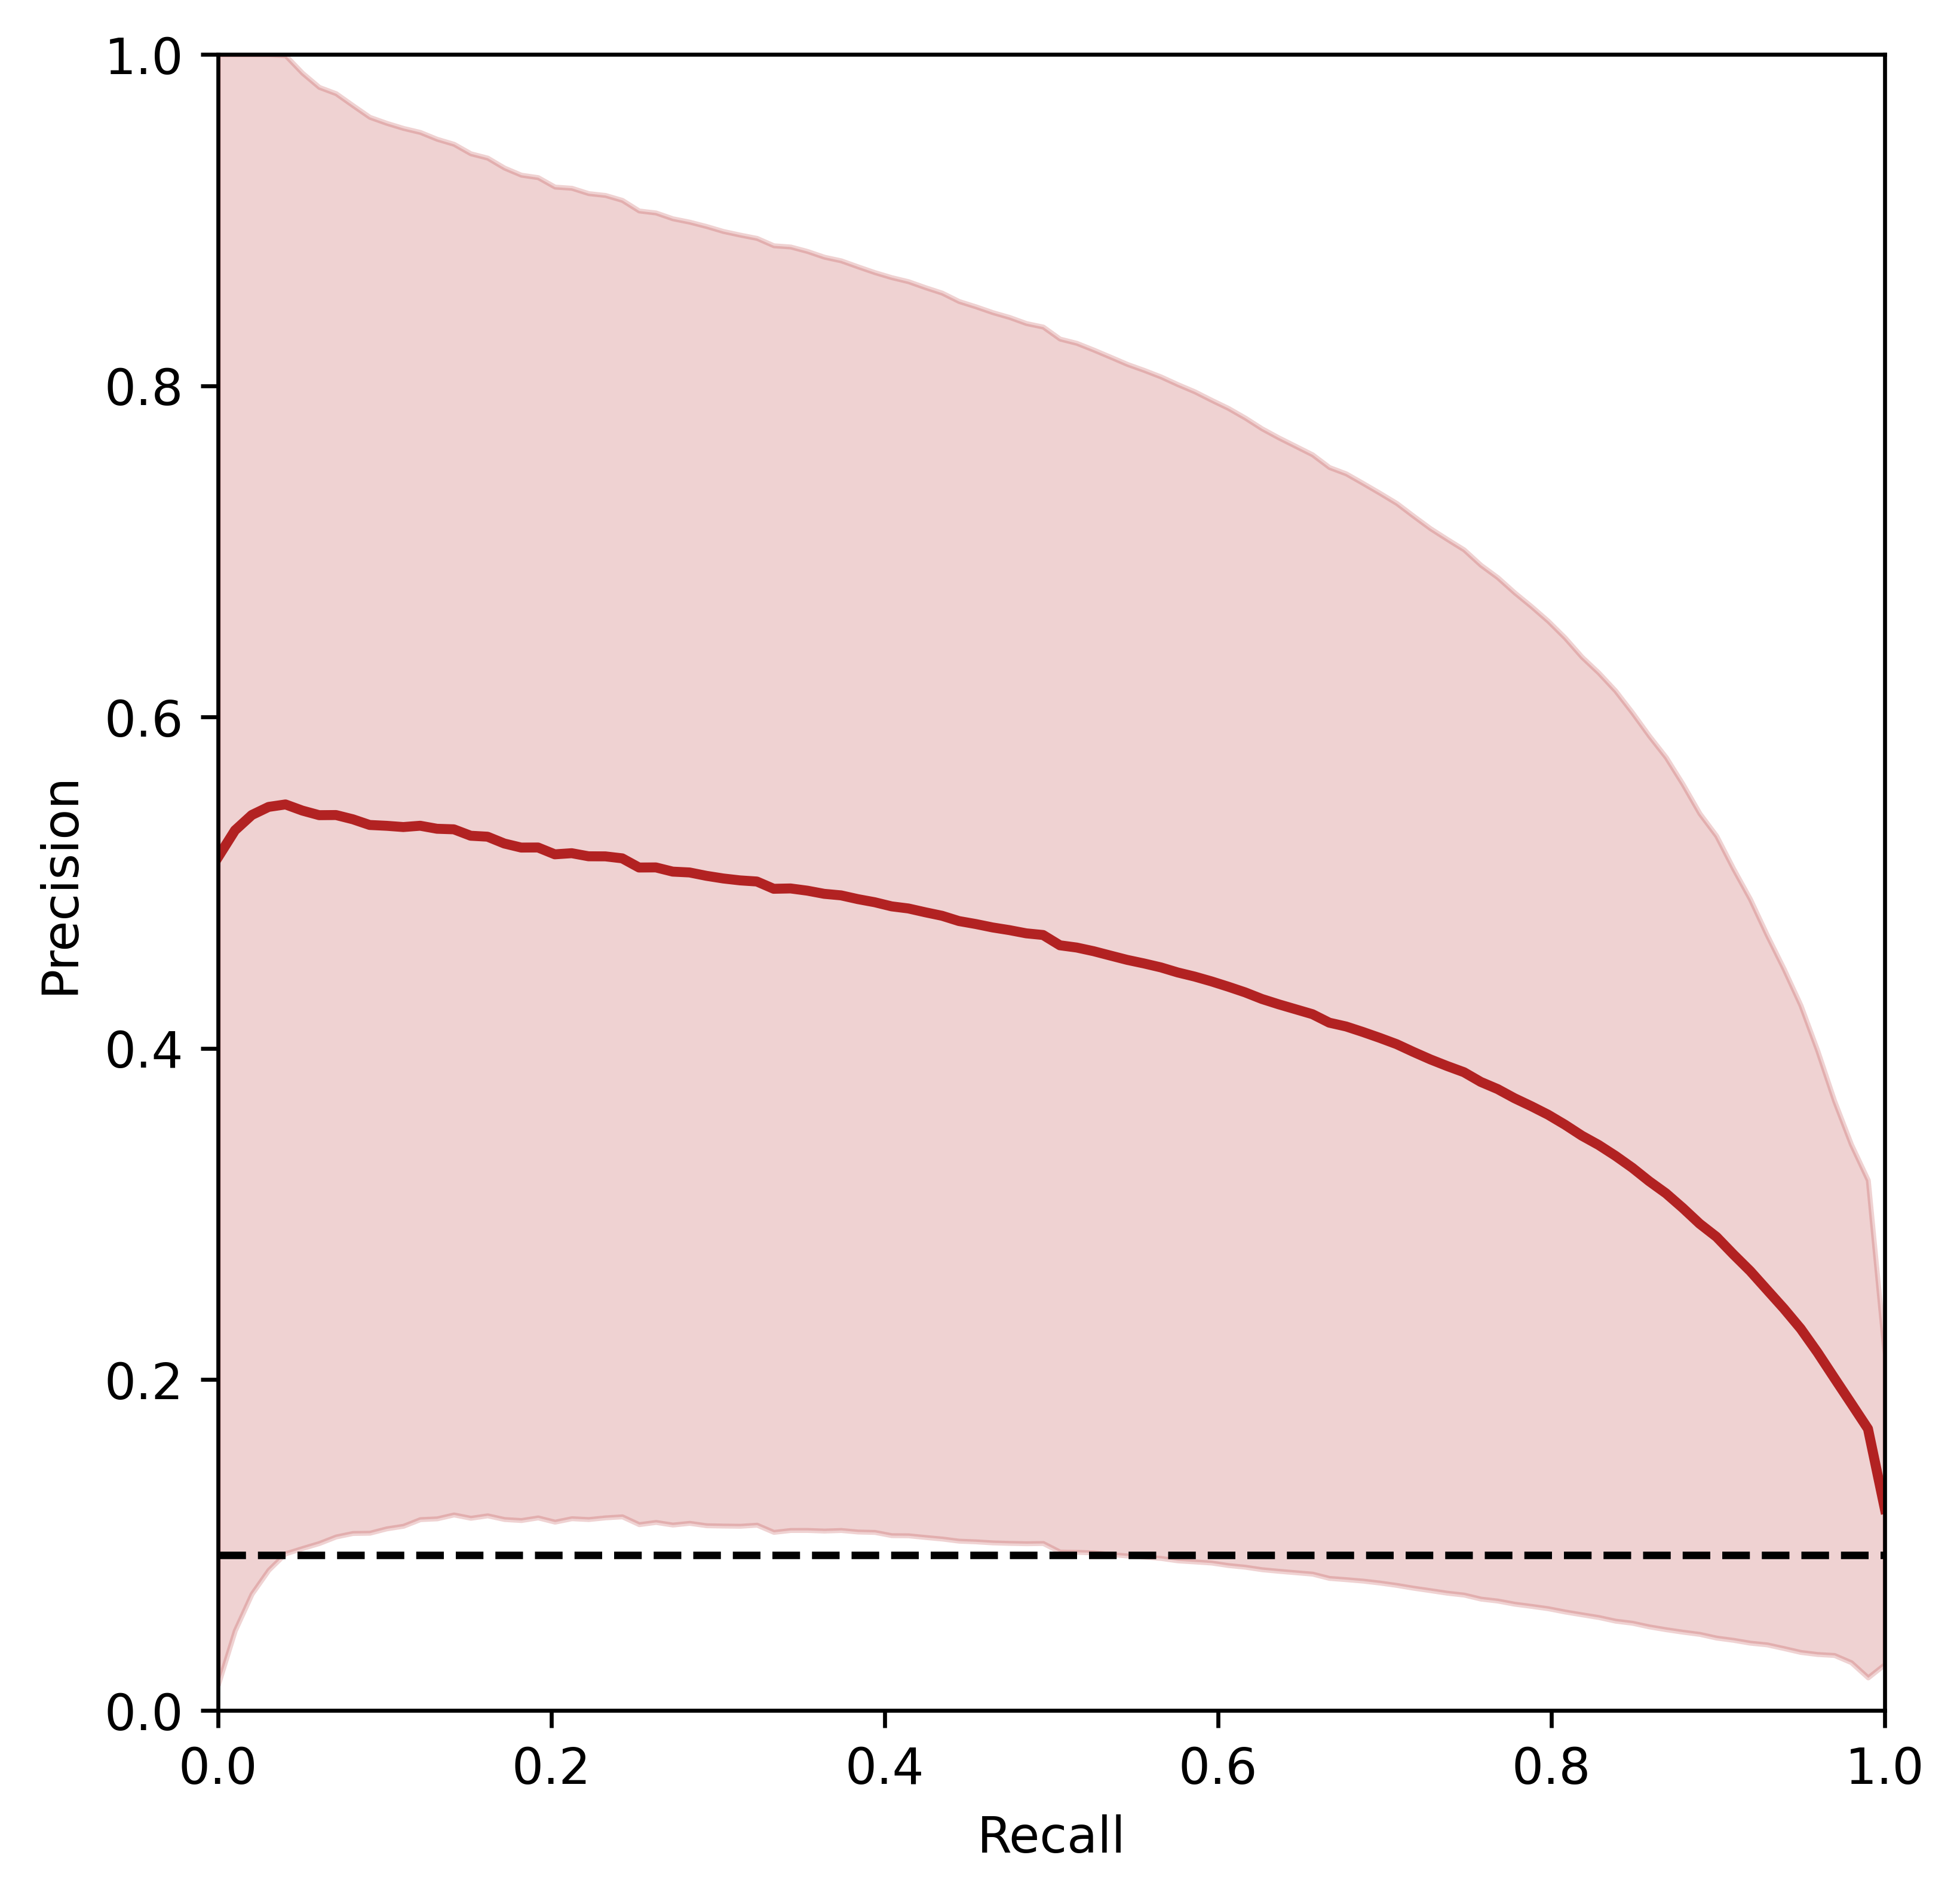

P2Rank+Cons 0.4620971673947827


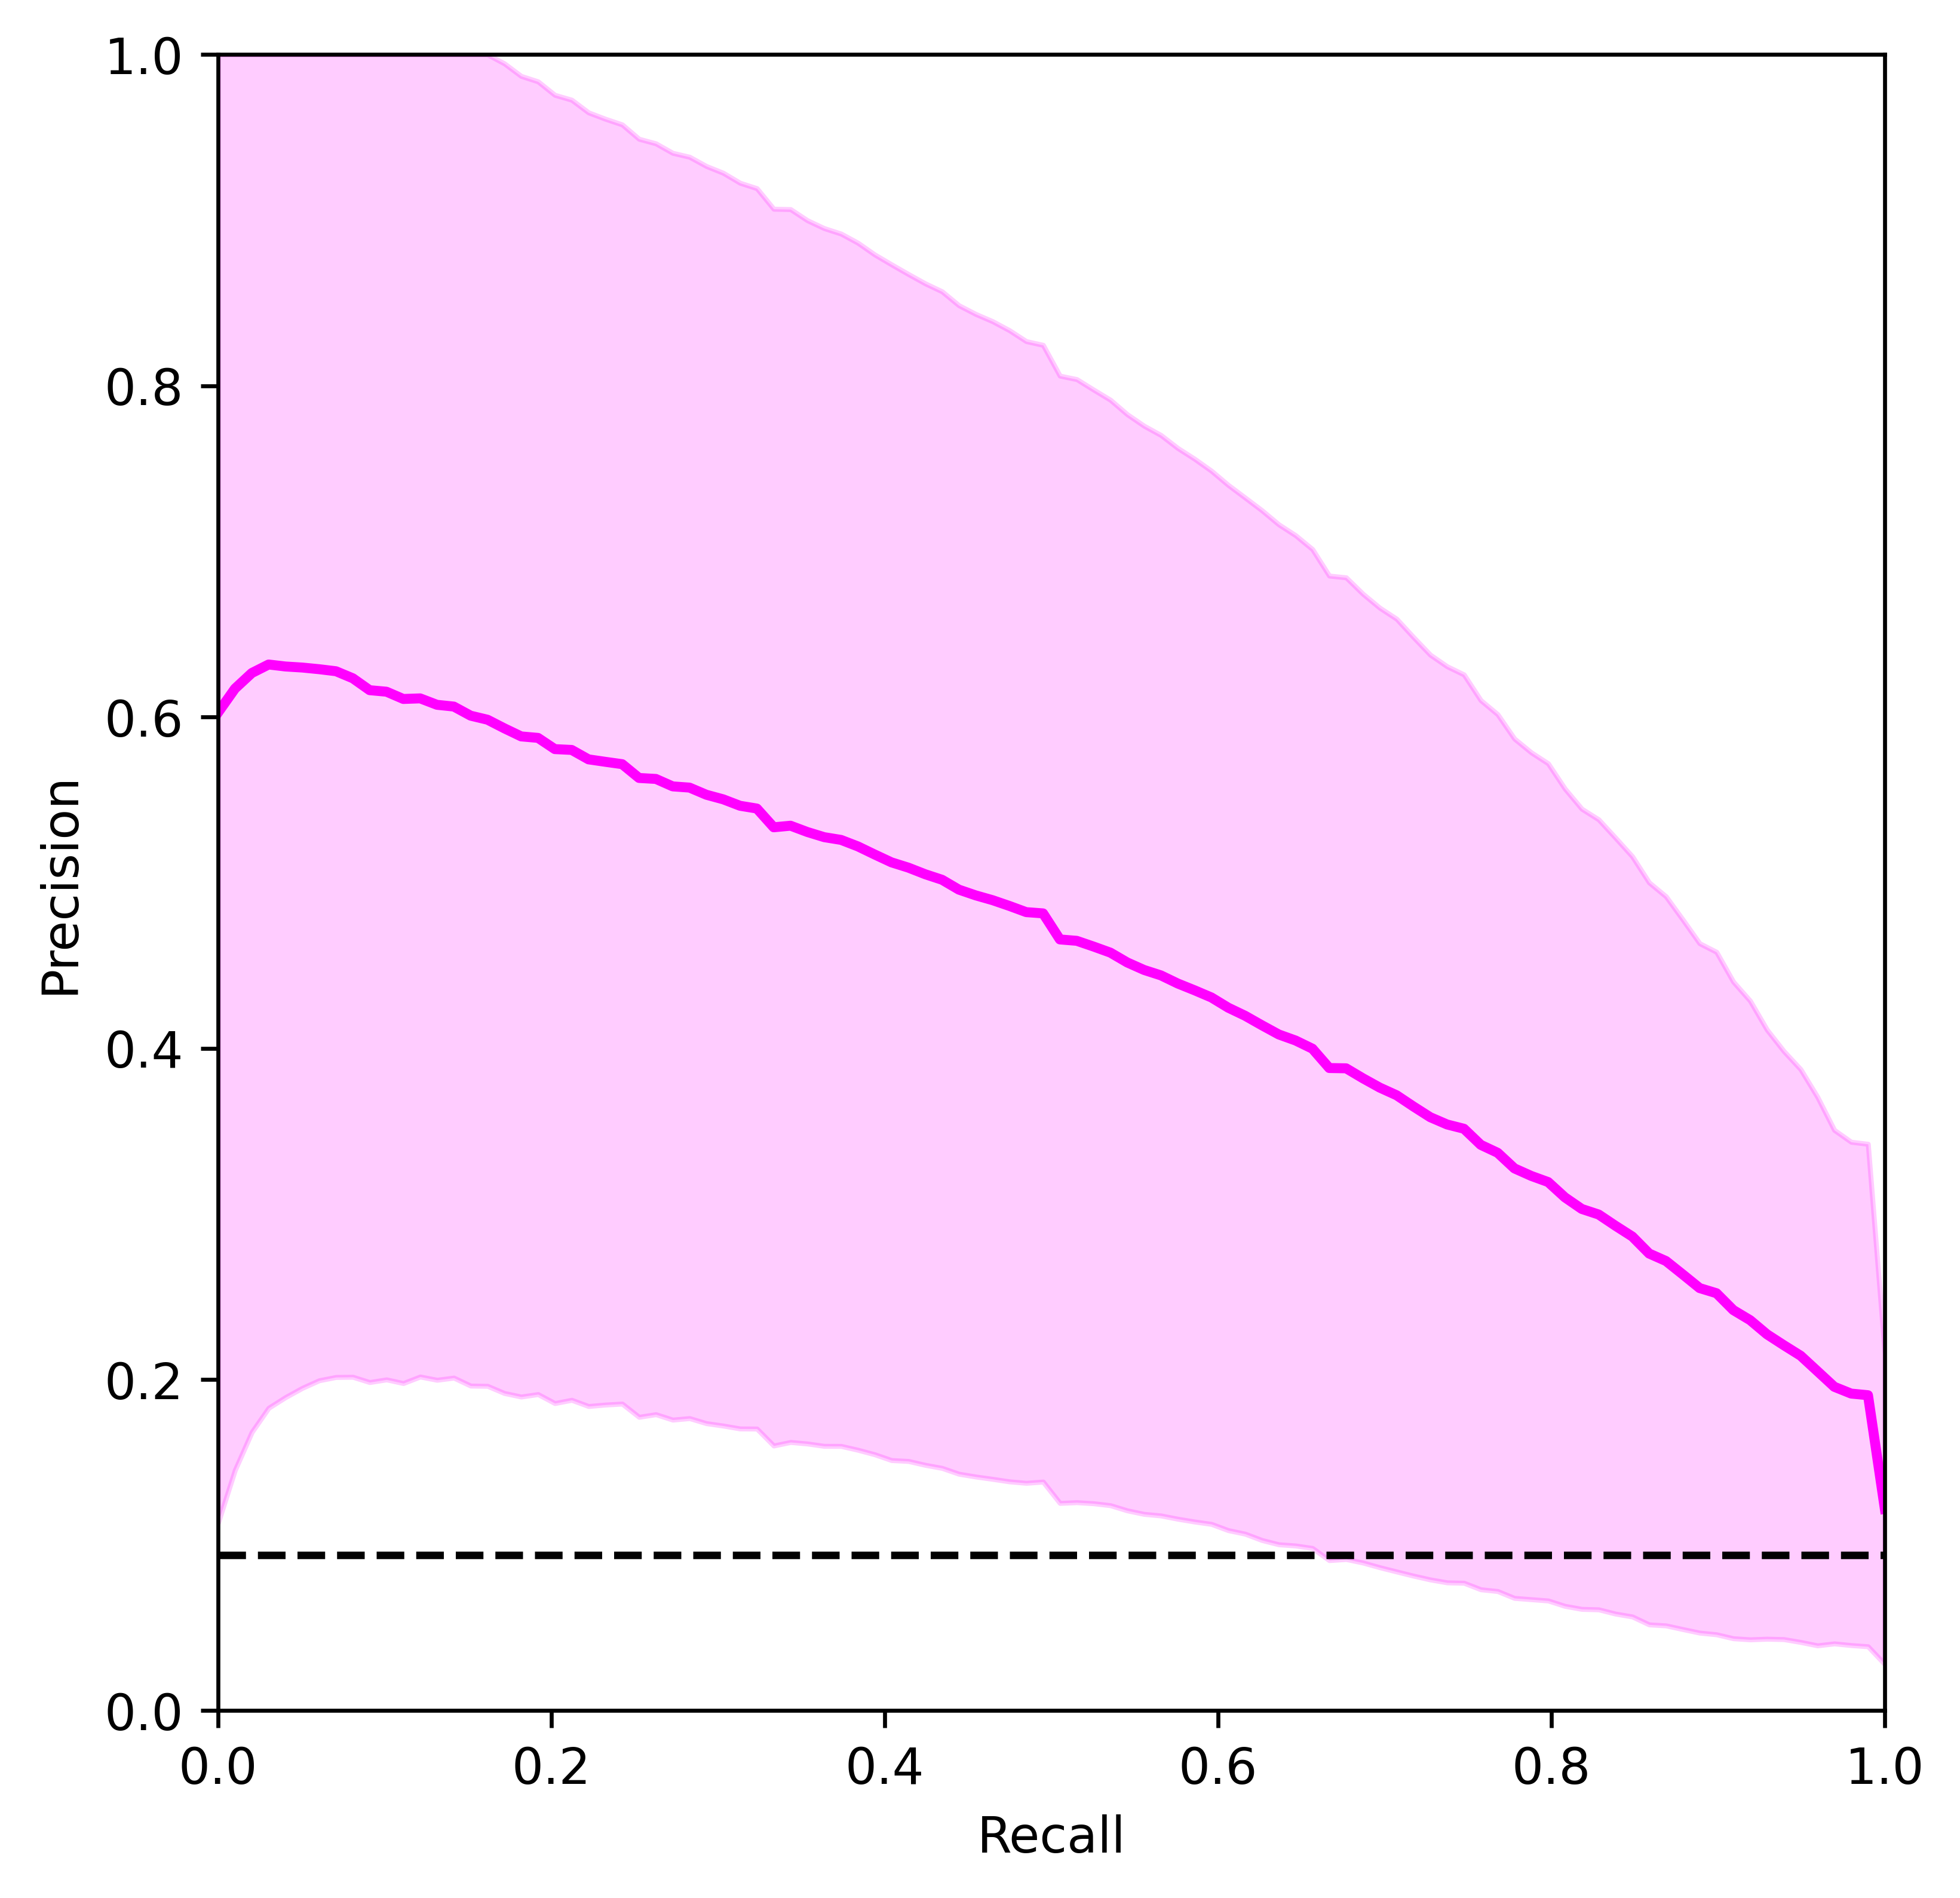

P2Rank 0.4184214917044838


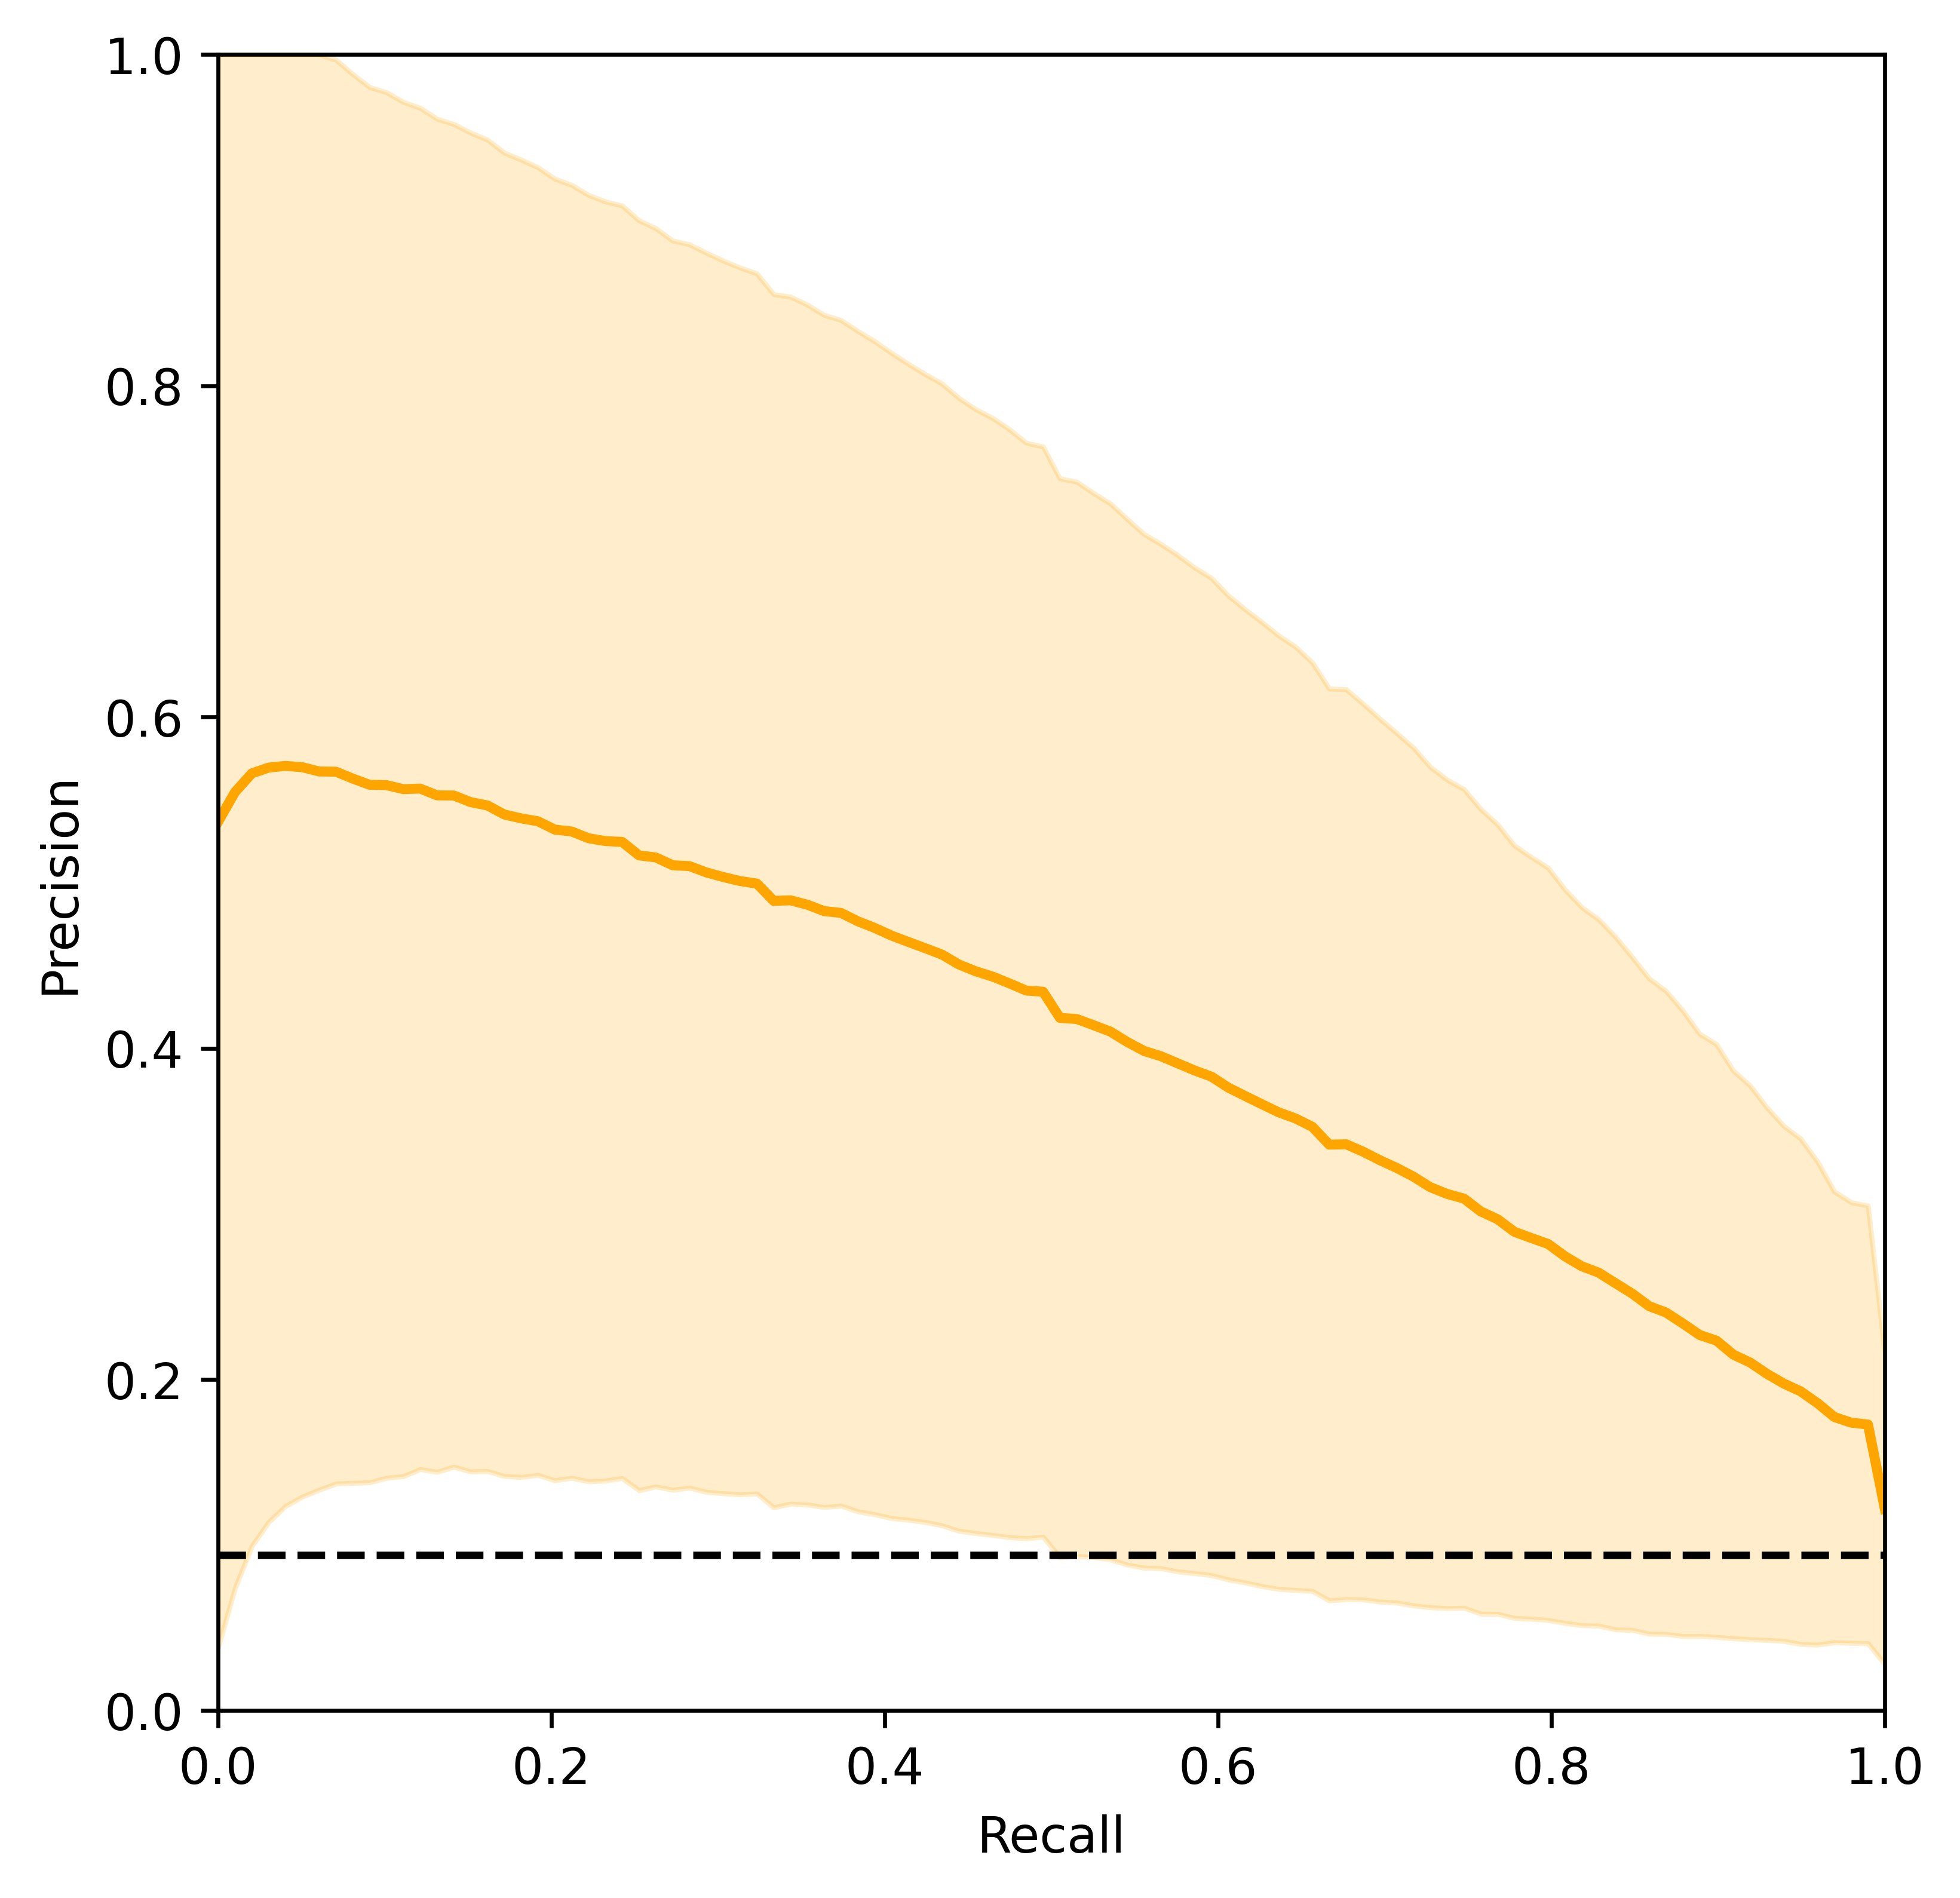

PocketFinder 0.33702780657133763


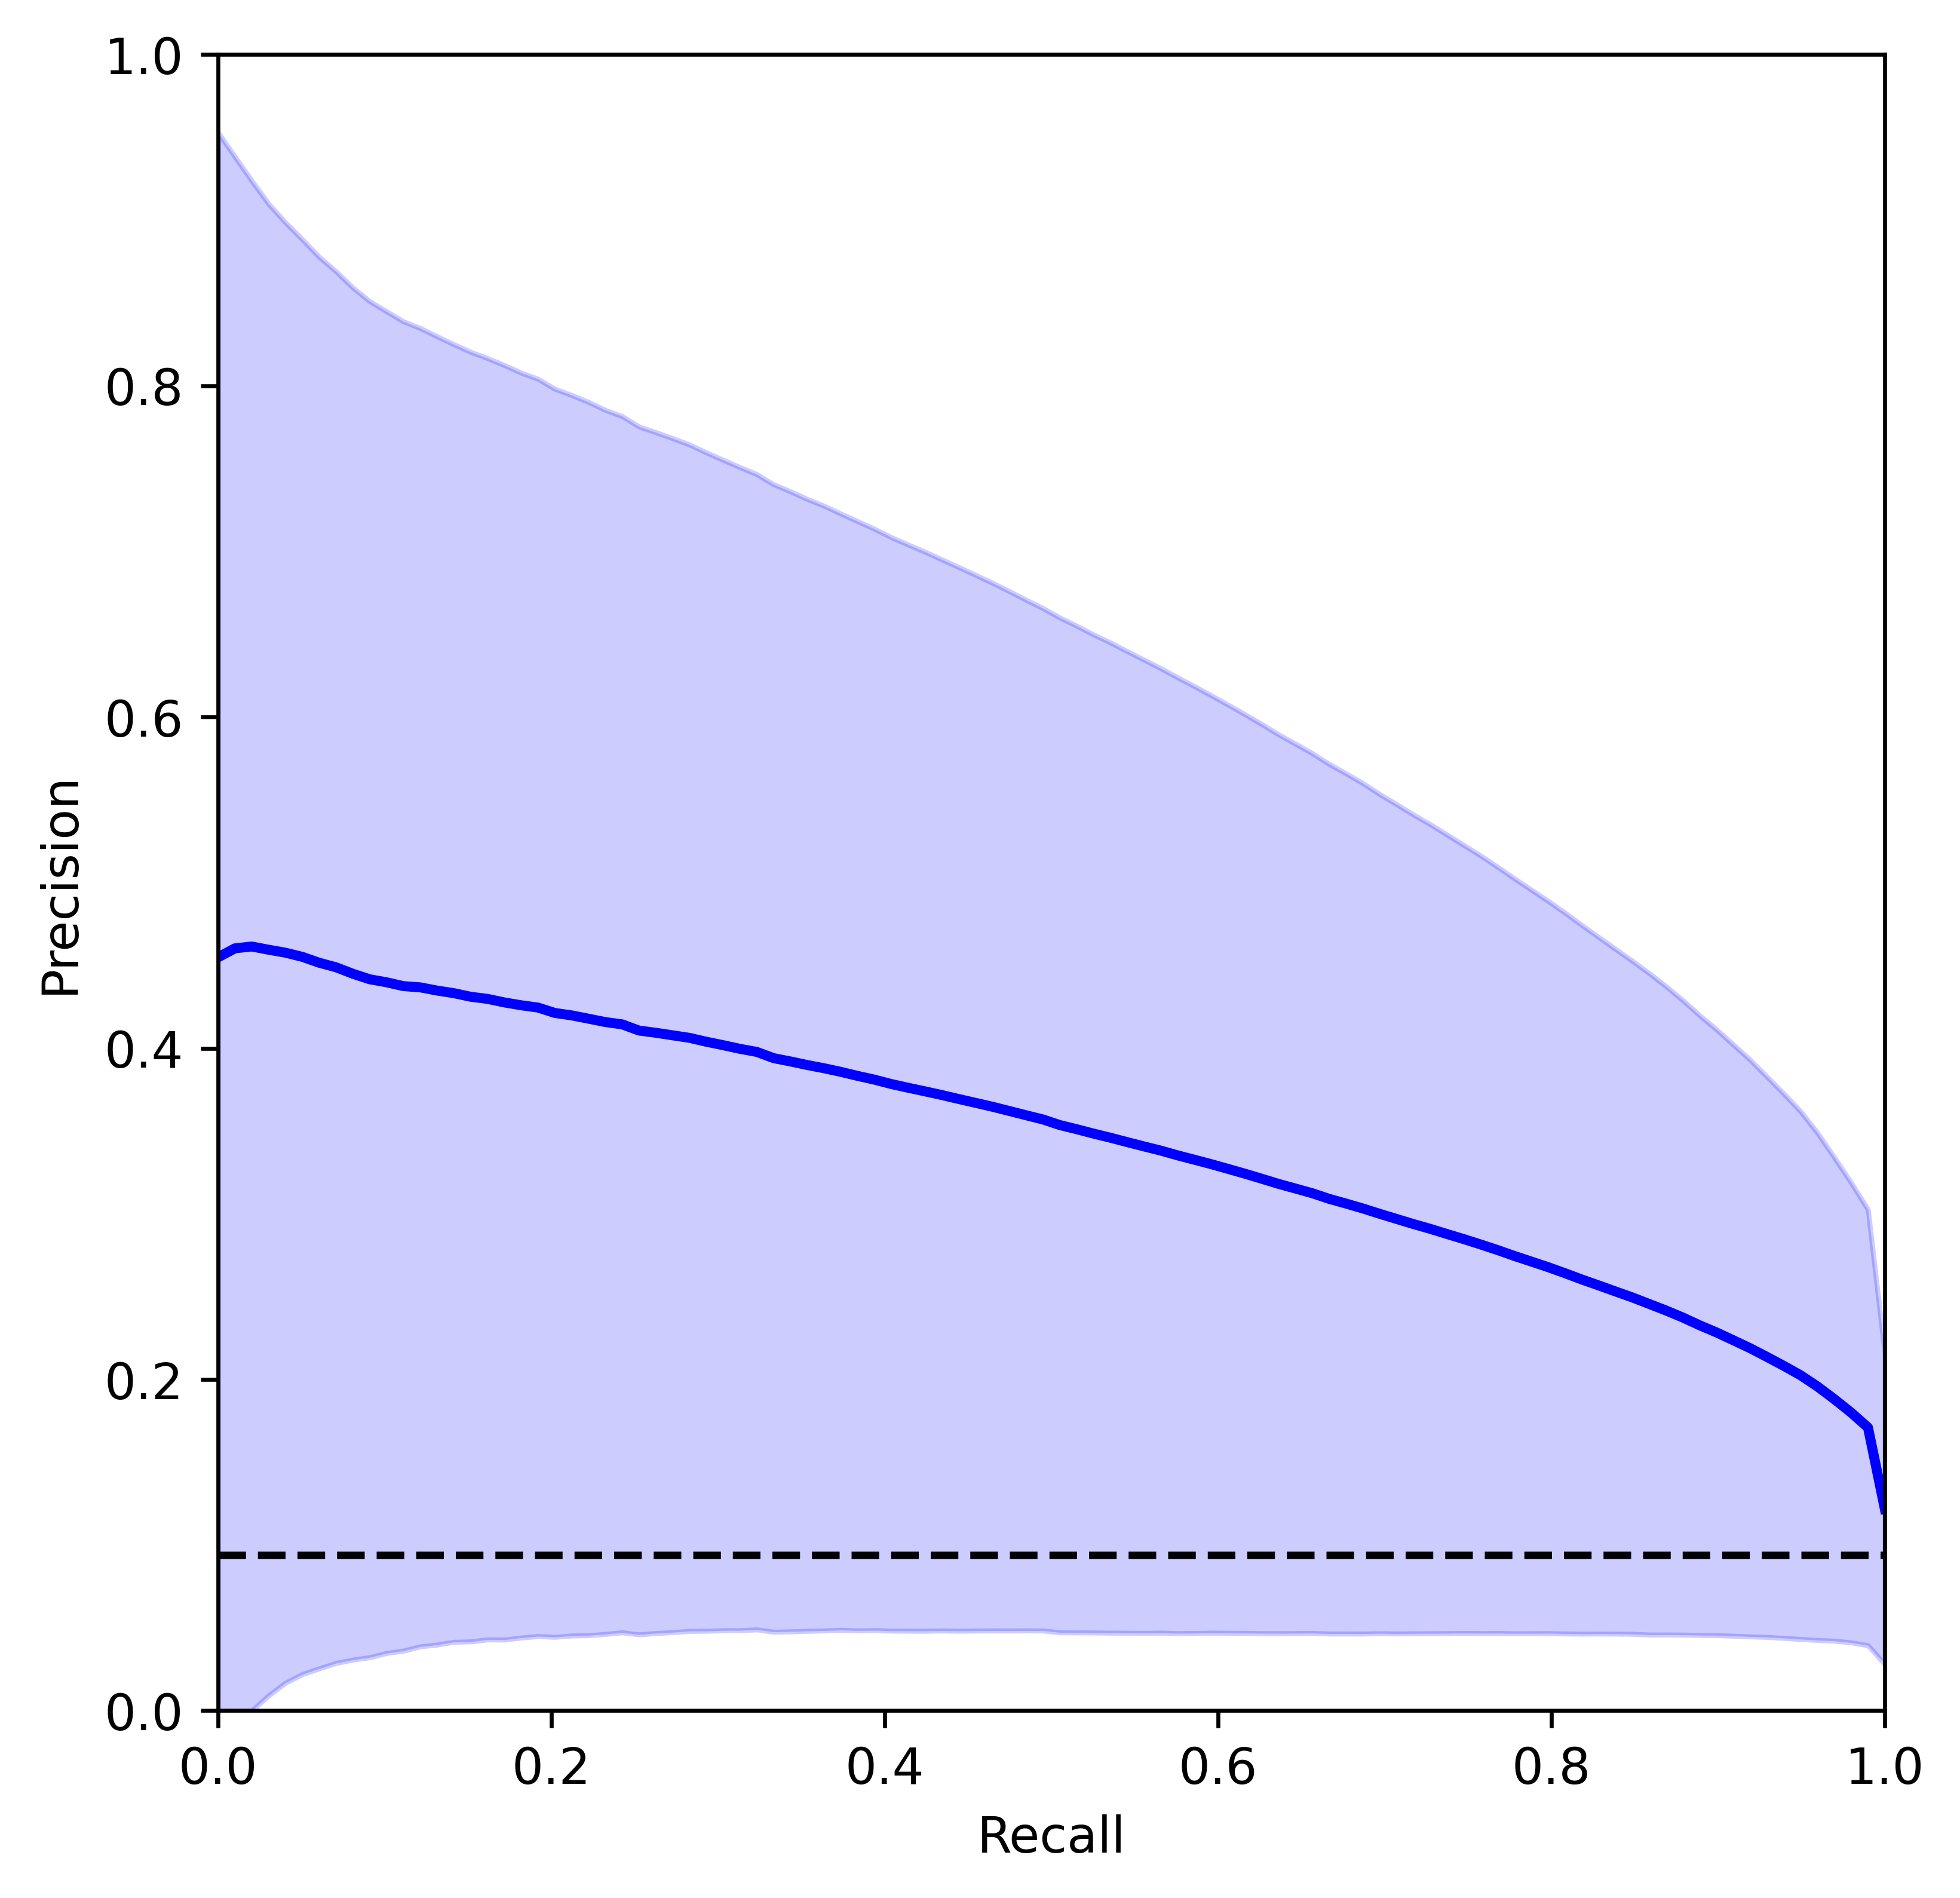

Ligsite 0.3826311677768992


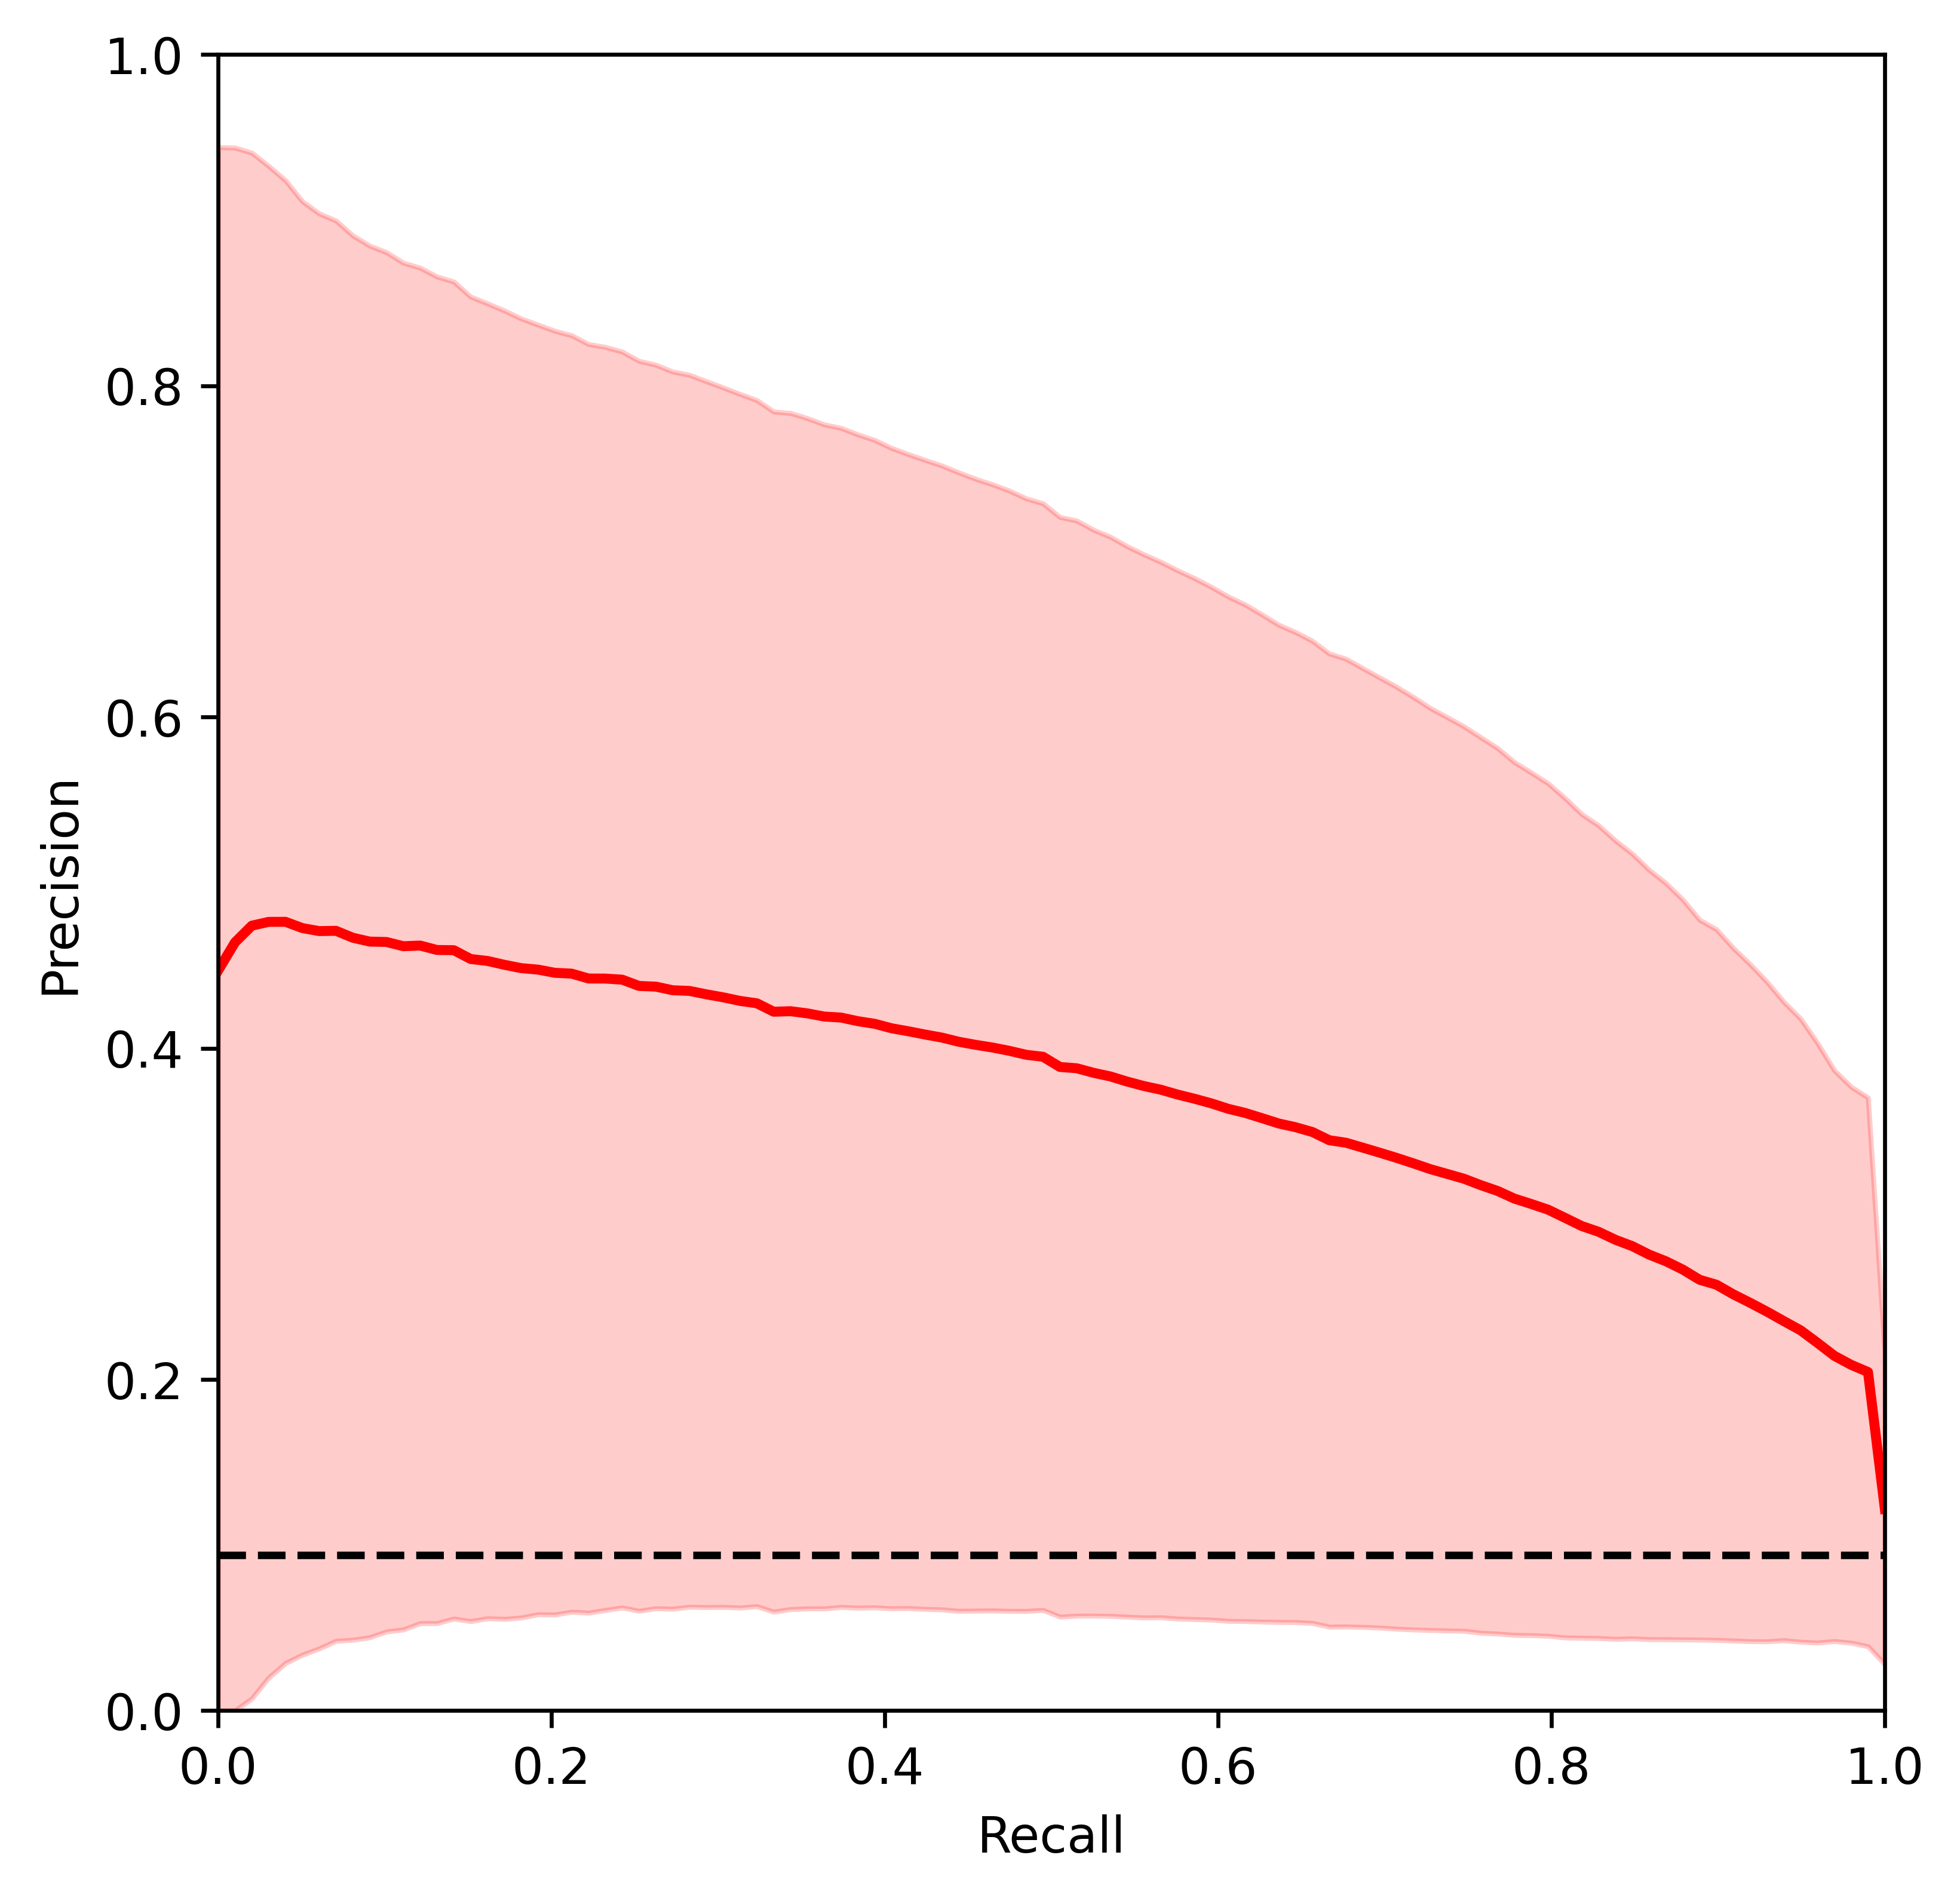

Surfnet 0.34972493859141307


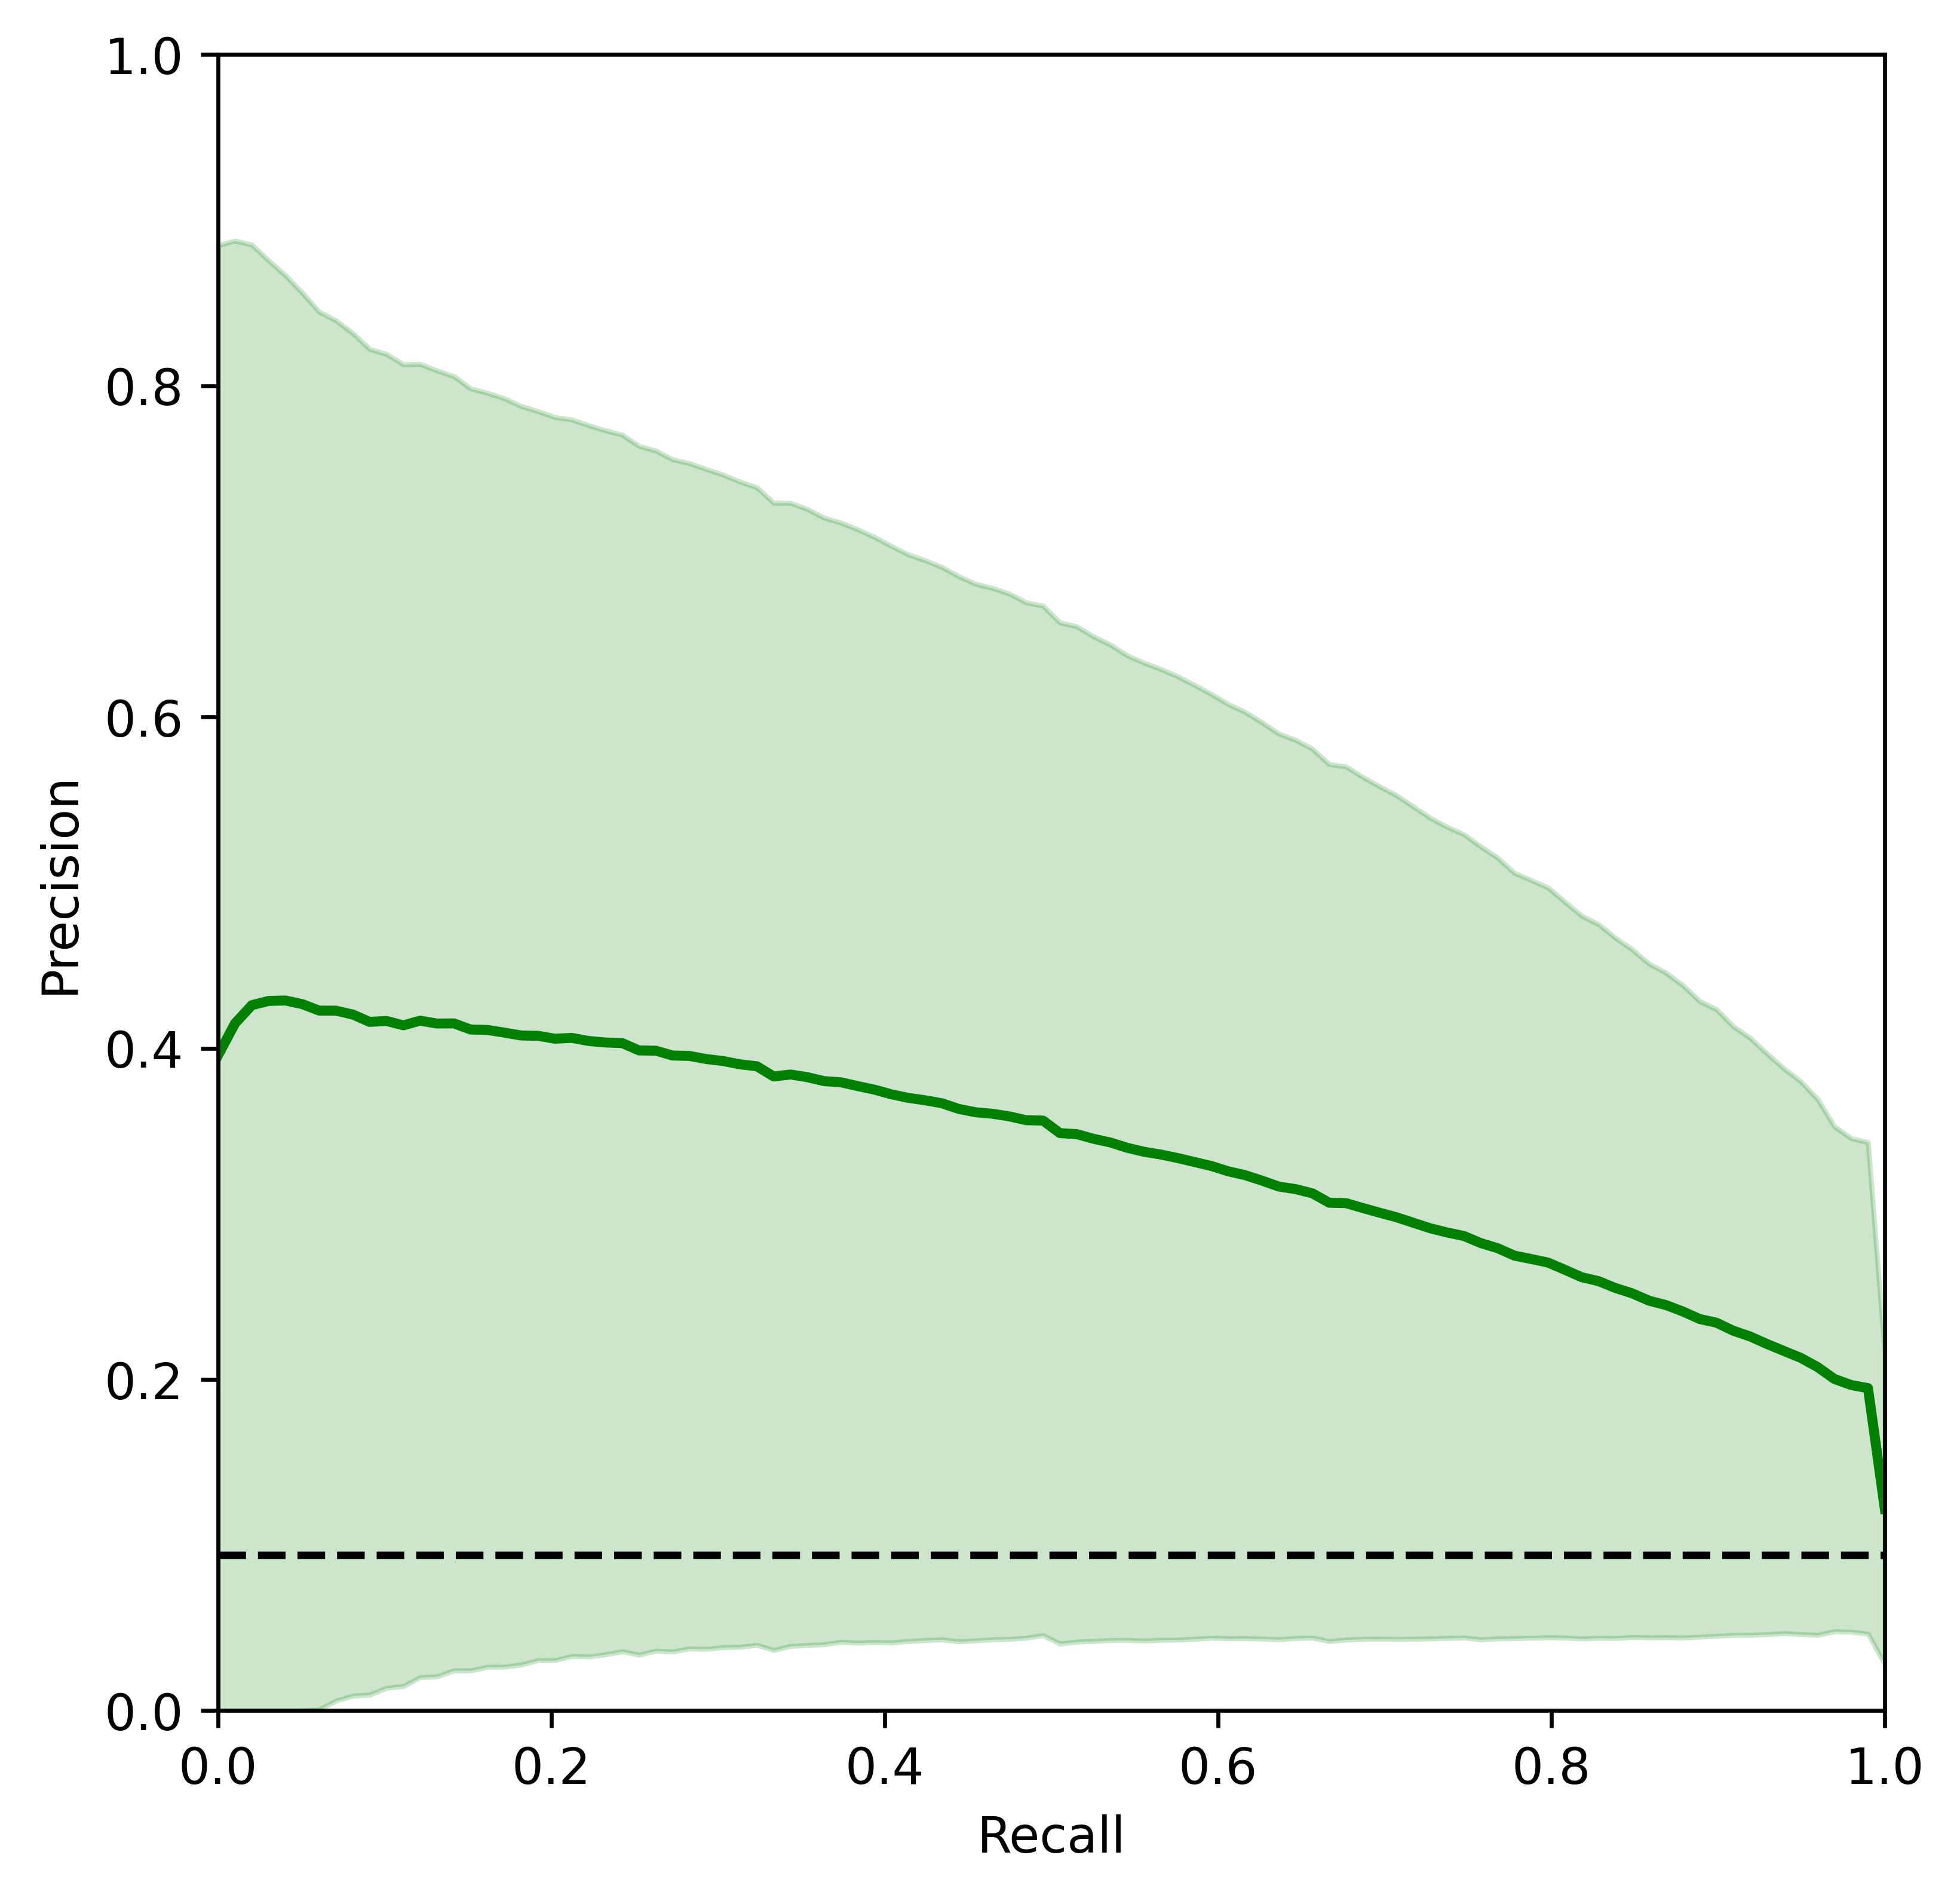

In [111]:
PR_data = {}
for method in methods:
    PR_data[method] = {}
    aps, recalls, precisions = plot_mean_precision_recall_curve2(ligandability_df_FILT, method=method, true_label_col='TRUE_LABEL', palette=palette, N_curves = None, DPI = 600, out = f"./figs/{method}_PR_curves_1SD.png")
    PR_data[method]["APs"] = aps
    PR_data[method]["recalls"] = recalls
    PR_data[method]["precisions"] = precisions

In [147]:
save_to_pickle(PR_data, "./results/PR_AP_variation.pkl")

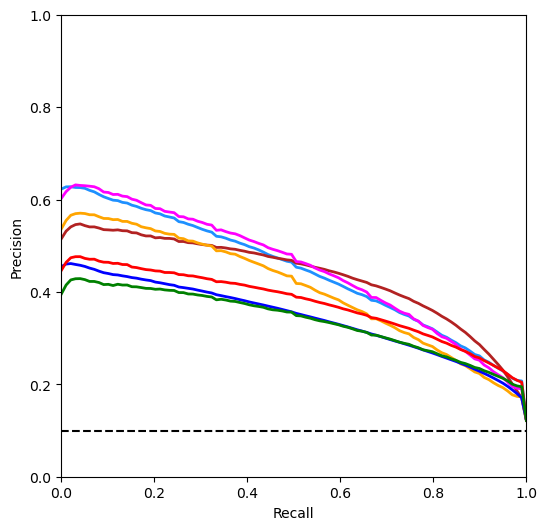

In [148]:
mean_recall = np.linspace(0, 1, 100)

plt.figure(figsize=(6, 6), dpi=100)

for k, v in PR_data.items():
    #aps = v["APs"]
    recalls = v["recalls"]
    precisions = v["precisions"]
    mean_precision = np.mean(precisions, axis=0)
    
    mean_ap = statistics.mean(aps)
    
    plt.plot(mean_recall, mean_precision, color=palette[k],
                 label=f'Mean PR (AP = {mean_ap:.2f})', lw=2)

# Plot the baseline (diagonal line)
plt.plot([0, 1], [0.1, 0.1], color='black', lw=1.5, linestyle='--', label='Baseline')
    
# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add legend
plt.legend().set_visible(False)

#plt.savefig("./figs/PR_AP_residue_level_MEANS.png")
    
plt.show()
    

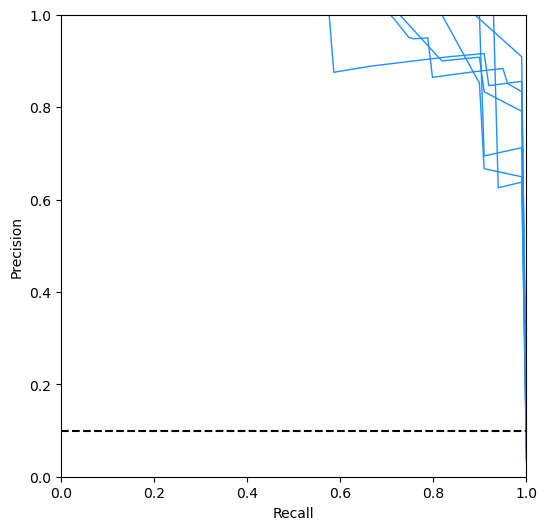

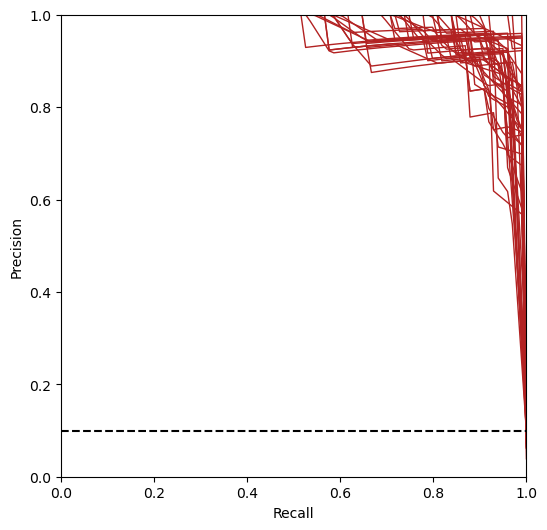

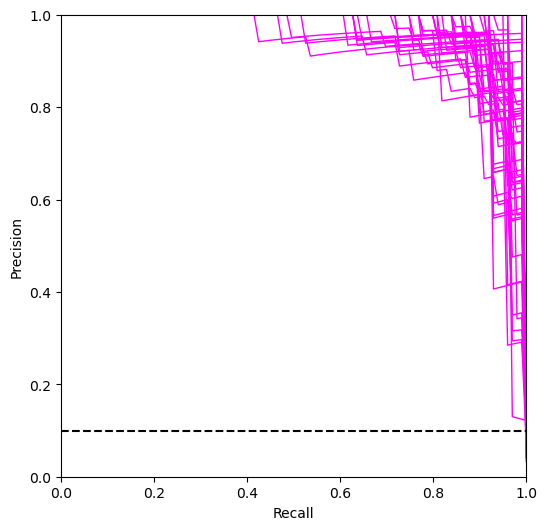

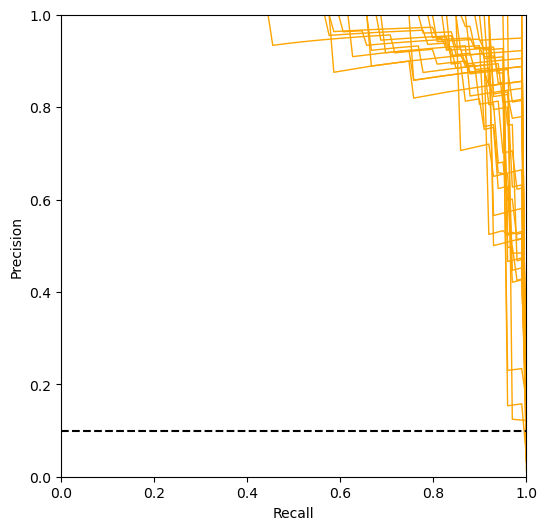

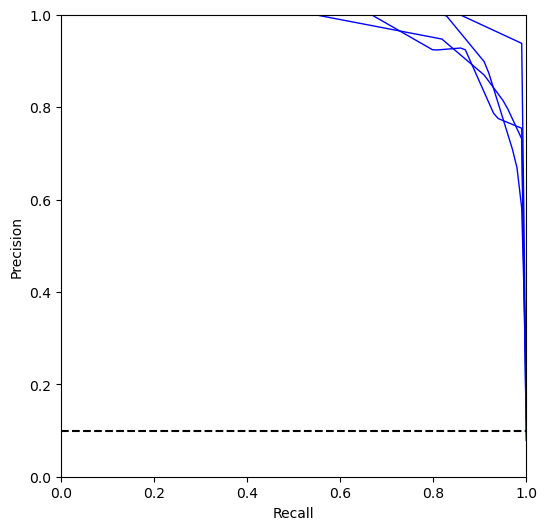

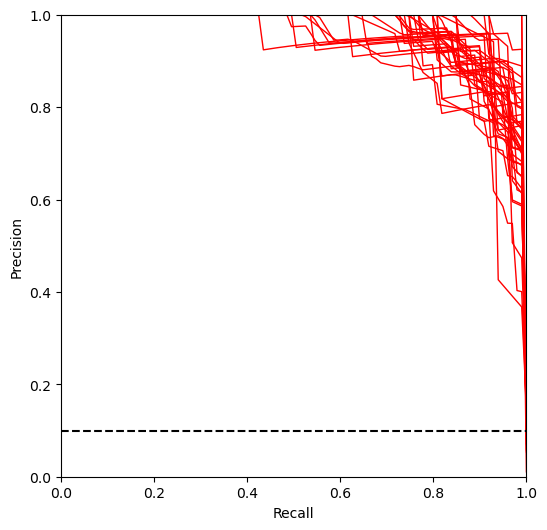

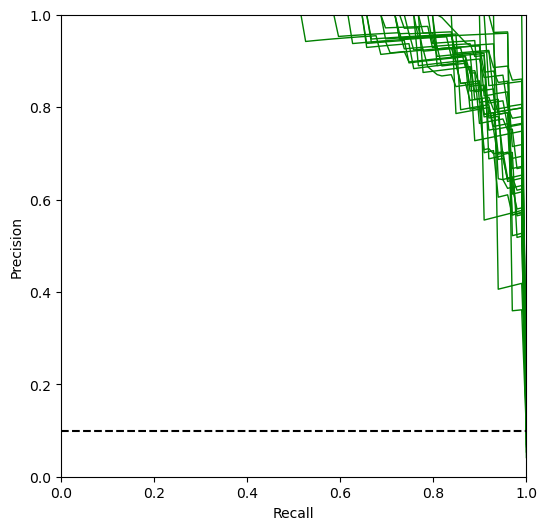

In [140]:
mean_recall = np.linspace(0, 1, 100)



for k, v in PR_data.items():
    aps = v["APs"]
    recalls = v["recalls"]
    precisions = v["precisions"]

    n_prots = len(aps)
    plt.figure(figsize=(6, 6), dpi=100)
    for i in range(n_prots):
        if aps[i]  > 0.95:
            
            plt.plot(recalls, precisions[i], color=palette[k],
                         label=f'PR (AP = {aps[i]:.2f})', lw=1, alpha = 1.0)
            # if i == 100:
            #     break
        
            # Plot the baseline (diagonal line)
    plt.plot([0, 1], [0.1, 0.1], color='black', lw=1.5, linestyle='--', label='Baseline')
        
    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Add legend
    plt.legend().set_visible(False)
        
    plt.show()
        
    